# Proyecto: Accidentes de tráfico

### Step 1: Problem definition

- Predicción de fatalidad de los accidentes de tráfico (si el accidente es mortal o no)
- Predicción de ocurrencia de accidentes de tráfico según las condiciones


### Step 2: Acquiring and loading the data set

In [117]:
import os
from dotenv import load_dotenv

load_dotenv()

os.environ['KAGGLE_USERNAME'] = os.getenv('KAGGLE_USERNAME')
os.environ['KAGGLE_KEY'] = os.getenv('KAGGLE_KEY')

In [118]:
import kagglehub
from kagglehub import KaggleDatasetAdapter

# Load the latest version
data = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "oktayrdeki/traffic-accidents",
  "traffic_accidents.csv"
)

print("First 5 records:", data.head())

/tmp/ipykernel_2192/2972283283.py:5: DeprecationWarning: load_dataset is deprecated and will be removed in future version.
  data = kagglehub.load_dataset(


First 5 records:                crash_date traffic_control_device weather_condition  \
0  07/29/2023 01:00:00 PM         TRAFFIC SIGNAL             CLEAR   
1  08/13/2023 12:11:00 AM         TRAFFIC SIGNAL             CLEAR   
2  12/09/2021 10:30:00 AM         TRAFFIC SIGNAL             CLEAR   
3  08/09/2023 07:55:00 PM         TRAFFIC SIGNAL             CLEAR   
4  08/19/2023 02:55:00 PM         TRAFFIC SIGNAL             CLEAR   

       lighting_condition first_crash_type trafficway_type  \
0                DAYLIGHT          TURNING     NOT DIVIDED   
1  DARKNESS, LIGHTED ROAD          TURNING        FOUR WAY   
2                DAYLIGHT         REAR END  T-INTERSECTION   
3                DAYLIGHT            ANGLE        FOUR WAY   
4                DAYLIGHT         REAR END  T-INTERSECTION   

            alignment roadway_surface_cond road_defect  \
0  STRAIGHT AND LEVEL              UNKNOWN     UNKNOWN   
1  STRAIGHT AND LEVEL                  DRY  NO DEFECTS   
2  STRAIGHT AND

In [119]:
# Mostrar información general del DataFrame
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209306 entries, 0 to 209305
Data columns (total 24 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   crash_date                     209306 non-null  object 
 1   traffic_control_device         209306 non-null  object 
 2   weather_condition              209306 non-null  object 
 3   lighting_condition             209306 non-null  object 
 4   first_crash_type               209306 non-null  object 
 5   trafficway_type                209306 non-null  object 
 6   alignment                      209306 non-null  object 
 7   roadway_surface_cond           209306 non-null  object 
 8   road_defect                    209306 non-null  object 
 9   crash_type                     209306 non-null  object 
 10  intersection_related_i         209306 non-null  object 
 11  damage                         209306 non-null  object 
 12  prim_contributory_cause       

### Step 3: Store the information

Para guardar los datos que conseguimos, utilizaremos SQLite.
Se omite el uso de insert ya que empleamos una función para crear la tabla, campos y almacenar los datos.
El uso de Join tampoco es posible, ya que únicamente utilizamos una fuente de datos.
Se emplearán diversas consultas para explorar los datos.

In [120]:
import sqlite3

#Creación de la db y tablas con datos

con = sqlite3.connect("../data/project_db.db")
data.to_sql('accident', con, if_exists='replace', index=False)

209306

### Step 4: Perform a descriptive analysis

In [121]:
data.describe()

,num_units,injuries_total,injuries_fatal,injuries_incapacitating,injuries_non_incapacitating,injuries_reported_not_evident,injuries_no_indication,crash_hour,crash_day_of_week,crash_month
count,209306.000000,209306.000000,209306.000000,209306.000000,209306.000000,209306.000000,209306.000000,209306.000000,209306.000000,209306.000000
mean,2.063300,0.382717,0.001859,0.038102,0.221241,0.121516,2.244002,13.373047,4.144024,6.771822
std,0.396012,0.799720,0.047502,0.233964,0.614960,0.450865,1.241175,5.603830,1.966864,3.427593
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
25%,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,9.000000,2.000000,4.000000
50%,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,14.000000,4.000000,7.000000
75%,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,3.000000,17.000000,6.000000,10.000000
max,11.000000,21.000000,3.000000,7.000000,21.000000,15.000000,49.000000,23.000000,7.000000,12.000000


#### Función de masa de probabilidad

/tmp/ipykernel_2192/3209131960.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=pmf.index, y=pmf.values, palette='viridis')


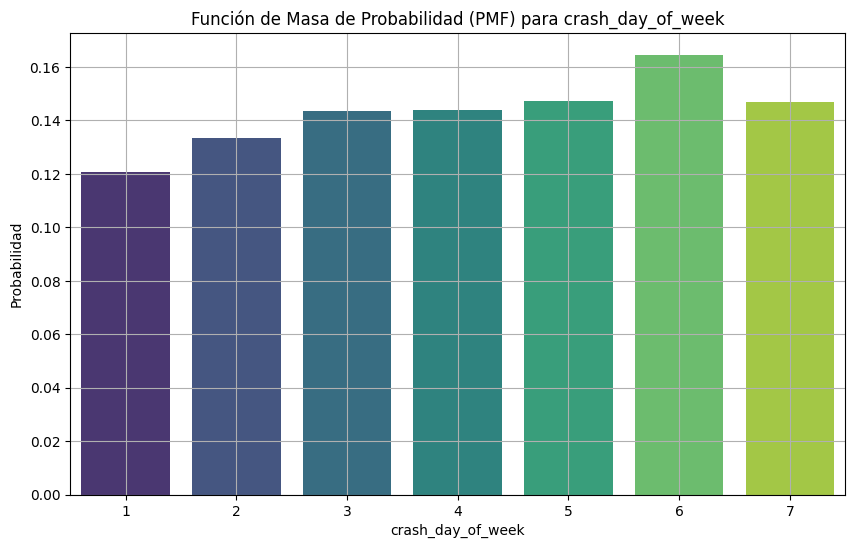

In [122]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Cálculo de la Función de Masa de Probabilidad (PMF)
def calculate_pmf(data, column):

    value_counts = data[column].value_counts() # Conteo de valores únicos
    total_values = len(data[column])
    
    pmf = value_counts / total_values # PMF = Frecuencia de cada valor / Total de valores
    return pmf

# Visualización de la PMF
def plot_pmf(pmf, column):
    plt.figure(figsize=(10, 6))
    sns.barplot(x=pmf.index, y=pmf.values, palette='viridis')
    plt.title(f'Función de Masa de Probabilidad (PMF) para {column}')
    plt.xlabel(column)
    plt.ylabel('Probabilidad')
    plt.grid(True)
    plt.show()

# PMF para crash_day_of_week (variable discreta) para ver la probabilidad de accidentes por día de la semana
pmf_crash_day = calculate_pmf(data, 'crash_day_of_week')
plot_pmf(pmf_crash_day, 'crash_day_of_week')


La anterior grafica nos muestra que los accidentes de tránsito tienen mayor probabilidad de ocurrir los sábados (día 6), posiblemente debido al aumento de la movilidad social, el ocio nocturno y el consumo de alcohol, mientras que los lunes presentan la menor incidencia (día 1), asociada a la rutina laboral y menor actividad recreativa.

Esta distribución refleja cómo los patrones de comportamiento humano y la dinámica social influyen directamente en la frecuencia de los incidentes, lo que sugiere la necesidad de estrategias preventivas focalizadas, como campañas de sensibilización y refuerzo de la vigilancia en los días críticos, con el fin de reducir los riesgos y mejorar la seguridad vial.

/tmp/ipykernel_2192/3209131960.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=pmf.index, y=pmf.values, palette='viridis')


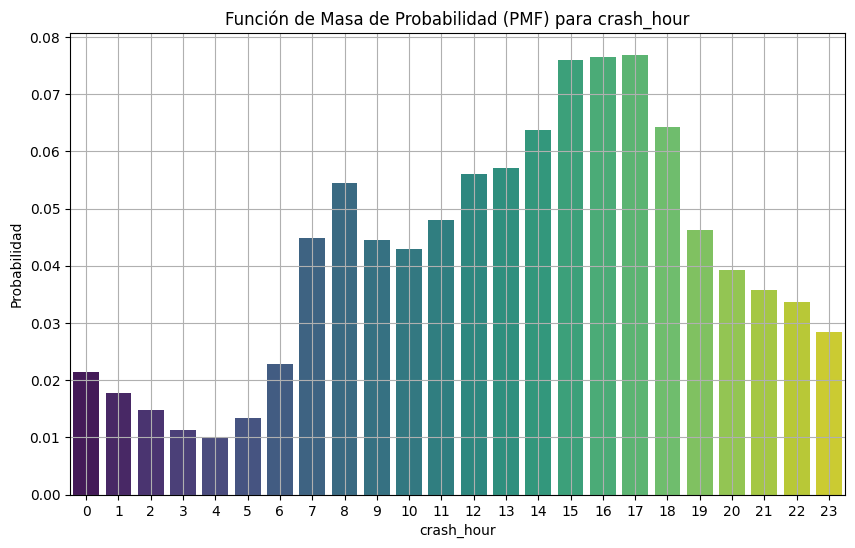

In [123]:
# PMF para crash_hour (variable discreta) para ver la probabilidad de accidentes por horario
pmf_crash_hour = calculate_pmf(data, 'crash_hour')
plot_pmf(pmf_crash_hour, 'crash_hour')

Lo anterior refleja que los accidentes de tránsito tienen una mayor probabilidad de ocurrir entre las 15:00 y las 17:00 horas, lo que coincide con el horario de mayor tráfico debido al cierre de la jornada laboral y escolar. La probabilidad disminuye progresivamente después de las 18:00 horas, reflejando la descongestión del tráfico. Las horas de la madrugada, especialmente entre las 3:00 y las 5:00 horas, presentan la menor incidencia, probablemente por la baja circulación de vehículos.

 Este patrón sugiere que la congestión vehicular y la fatiga pueden ser factores clave en la frecuencia de los accidentes, destacando la necesidad de implementar medidas de regulación y concienciación en los horarios de mayor riesgo para mitigar la siniestralidad vial.

/tmp/ipykernel_2192/3209131960.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=pmf.index, y=pmf.values, palette='viridis')


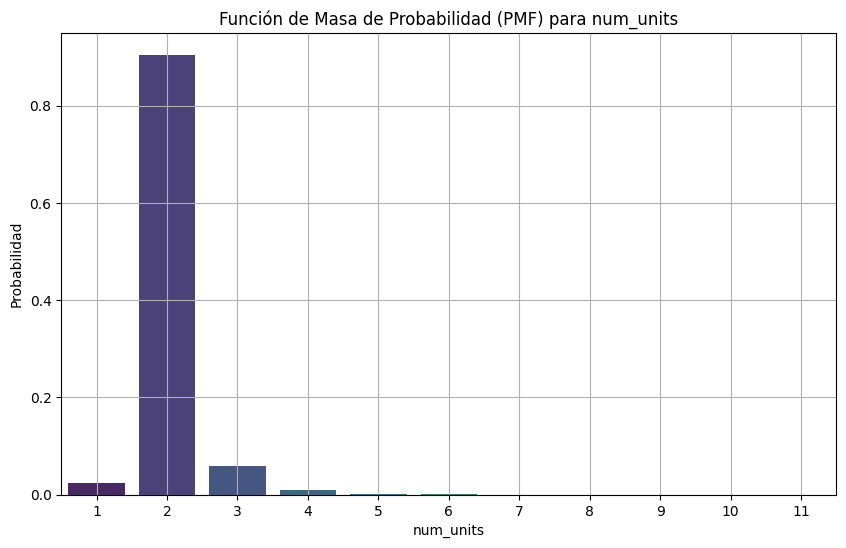

In [124]:
# PMF para num_units (variable discreta) para ver la probabilidad de accidentes por número de vehículos involucrados
pmf_num_units = calculate_pmf(data, 'num_units')
plot_pmf(pmf_num_units, 'num_units')

Esto que la mayoría de los accidentes de tránsito involucran dos unidades, con una probabilidad significativamente alta en comparación con otros valores, lo que sugiere que los choques entre dos vehículos son los más comunes. Los incidentes con una sola unidad, posiblemente relacionados con colisiones contra objetos fijos o pérdida de control, presentan una probabilidad mucho menor. Los accidentes que involucran tres o más unidades son escasos, lo que indica que los eventos de múltiples vehículos son menos frecuentes. 

Esta distribución destaca la relevancia de las colisiones frontales o laterales entre dos vehículos como causa predominante, lo que sugiere la necesidad de fortalecer las medidas de prevención en cruces viales y vías de alta circulación para minimizar este tipo de incidentes.

/tmp/ipykernel_2192/3209131960.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=pmf.index, y=pmf.values, palette='viridis')


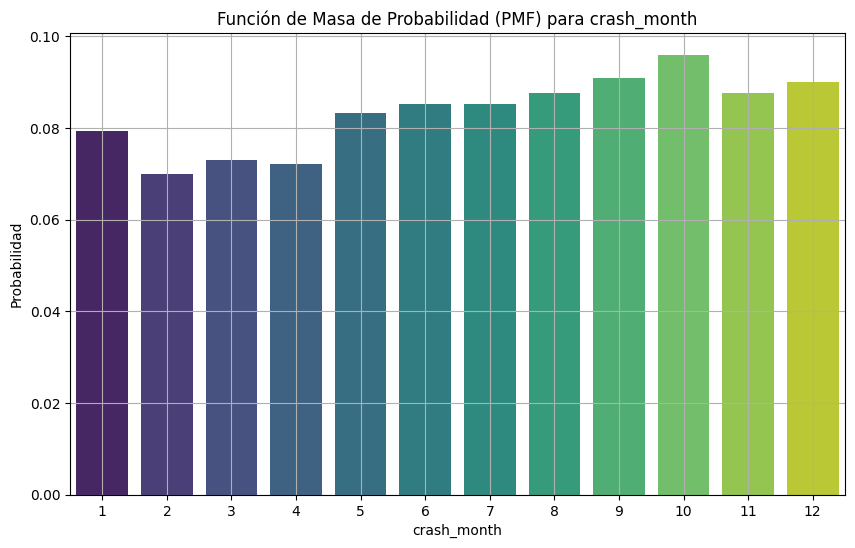

In [125]:
# PMF para crash_month (variable discreta) para ver la probabilidad de accidentes por temporada (mes)
pmf_crash_month = calculate_pmf(data, 'crash_month')
plot_pmf(pmf_crash_month, 'crash_month')

 Esto evidencia que los incidentes de tránsito se distribuyen de manera relativamente uniforme a lo largo del año, con una ligera tendencia al aumento en los meses finales, especialmente en octubre. Este patrón puede estar relacionado con factores estacionales como el incremento de la movilidad por festividades, mayor afluencia vehicular o condiciones climáticas que afectan la seguridad vial. 
 
 La disminución en los primeros meses podría asociarse a la reducción del tráfico por vacaciones o ajustes económicos de inicio de año. Esta visión integral permite identificar posibles periodos críticos para implementar campañas de prevención y reforzar la vigilancia en los meses con mayor probabilidad de accidentes.

#### Función de densidad de probabilidad

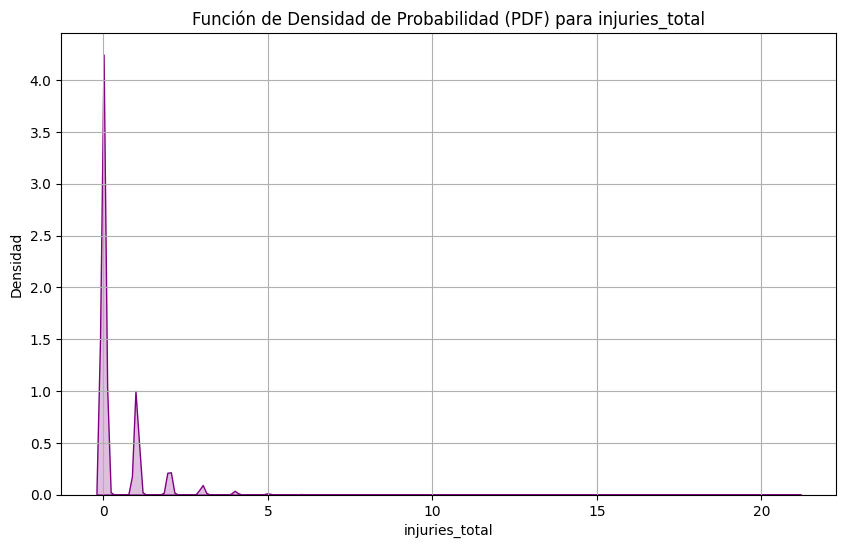

In [126]:
# Función para graficar la PDF
def plot_pdf(data, column):
    plt.figure(figsize=(10, 6))
    sns.kdeplot(data[column], fill=True, color="purple")
    plt.title(f"Función de Densidad de Probabilidad (PDF) para {column}")
    plt.xlabel(column)
    plt.ylabel("Densidad")
    plt.grid(True)
    plt.show()

# PDF para injuries_total
plot_pdf(data, 'injuries_total')


Lo anterior indica que la mayoría de los incidentes de tránsito involucran un número bajo de lesiones, con una densidad máxima cercana a cero, lo que indica que la probabilidad de tener pocas lesiones es significativamente mayor que la de tener muchas. La distribución muestra una fuerte asimetría positiva, con valores extremos que se alejan hacia la derecha, lo que sugiere que los eventos con muchas lesiones son poco comunes.

Este patrón puede estar relacionado con la naturaleza de los accidentes, donde la mayoría de los incidentes tienden a ser de menor gravedad debido a factores como las condiciones climáticas, el tipo de vía o el cumplimiento de las normas de tránsito.

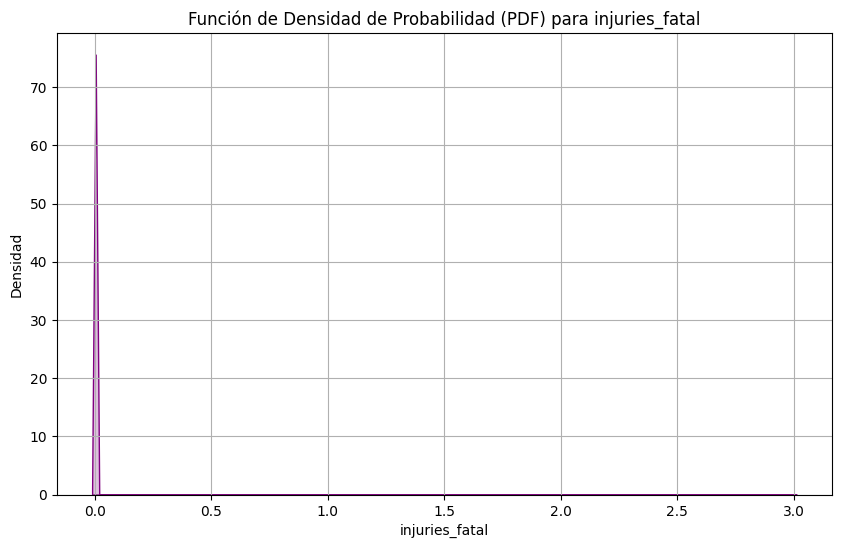

In [127]:
# PDF para injuries_fatal
plot_pdf(data, 'injuries_fatal')

Esto muestra una alta concentración en el valor cero, lo que sugiere que la gran mayoría de los incidentes de tránsito no resultan en víctimas fatales. La densidad disminuye a medida que aumenta el número de fatalidades, evidenciando que los accidentes con muertes son eventos altamente improbables. 

Esta distribución refleja que los factores asociados con la gravedad de los accidentes, como la velocidad, el tipo de vía, o las condiciones climáticas, influyen en la baja frecuencia de fatalidades. La presencia de unos pocos valores distintos de cero destaca la necesidad de medidas preventivas para reducir la ocurrencia de estos eventos excepcionales.

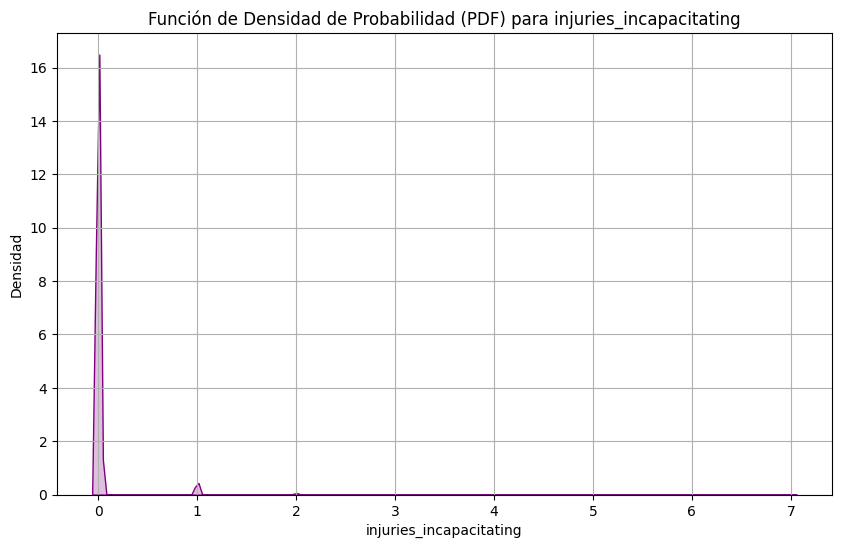

In [128]:
# PDF para injuries_incapacitating
plot_pdf(data, 'injuries_incapacitating')

De manera similar, esto también revela que la mayoría de los incidentes de tránsito no generan lesiones incapacitantes, con una alta concentración en el valor cero. La densidad disminuye rápidamente a medida que aumentan las lesiones, indicando que los accidentes con consecuencias graves son poco frecuentes. 

Esta distribución sugiere que, si bien la mayoría de los accidentes tienen consecuencias leves, los eventos con lesiones incapacitantes podrían estar relacionados con factores como la velocidad del vehículo, el uso de dispositivos de seguridad o las condiciones del entorno. 

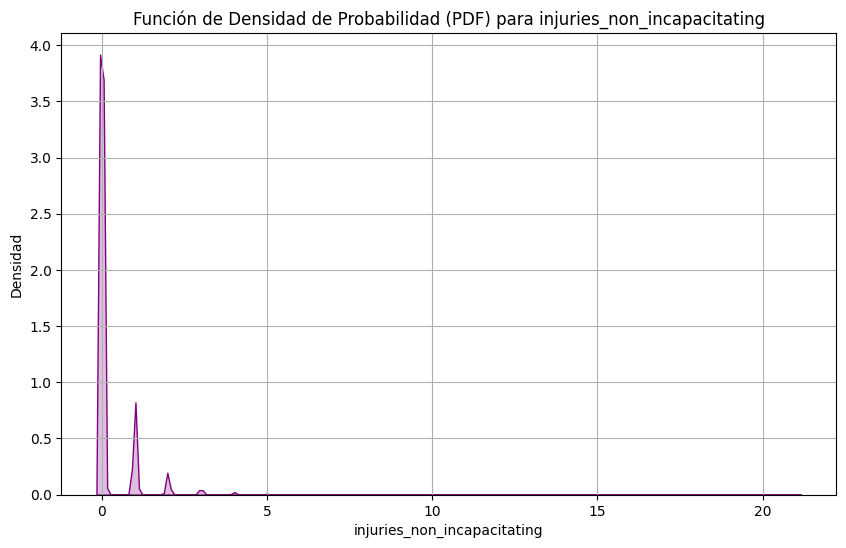

In [129]:
# PDF para injuries_non_incapacitating
plot_pdf(data, 'injuries_non_incapacitating')

Lo anterior muestra que la mayoría de los accidentes no generan este tipo de lesiones o presentan valores muy bajos, mientras que solo una minoría tiene un número elevado, evidenciando una distribución sesgada con una larga cola derecha, esto sugiere que, aunque la mayoría de los accidentes son leves en términos de lesiones no incapacitantes, hay casos menos frecuentes pero más graves.

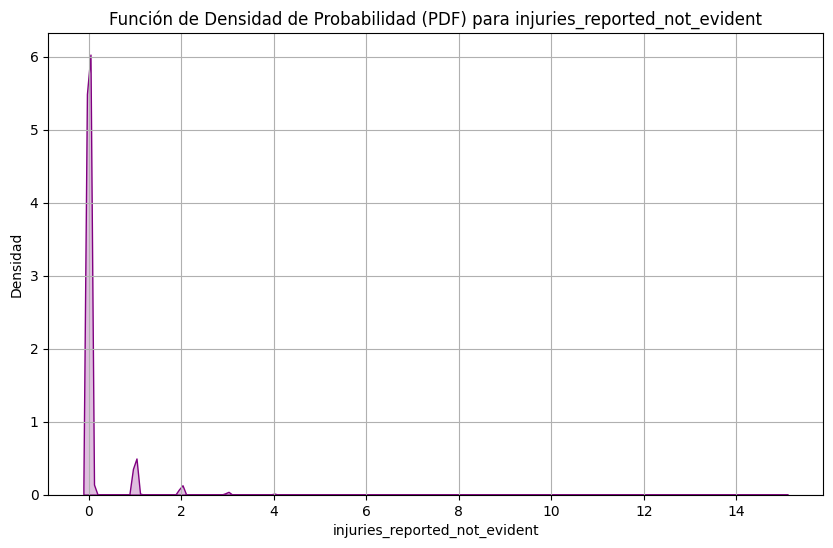

In [130]:
# PDF para injuries_reported_not_evident
plot_pdf(data, 'injuries_reported_not_evident')

Esto relfeja que se presenta una fuerte concentración en valores cercanos a 0, lo que indica que en la mayoría de los accidentes no se reportan lesiones evidentes, aunque existen casos con valores más altos pero poco frecuentes. Esta distribución sugiere que la mayoría de los accidentes son de baja severidad en términos de lesiones visibles, pero pueden existir lesiones internas o síntomas tardíos. 

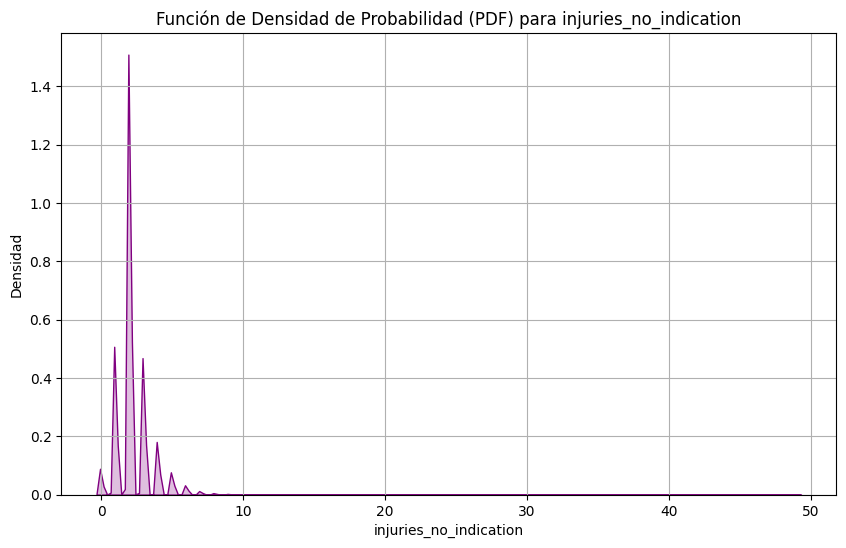

In [131]:
# PDF para injuries_no_indication
plot_pdf(data, 'injuries_no_indication')

Esto refleja una fuerte concentración en valores bajos, lo que sugiere que la mayoría de los accidentes reportados no presentan indicios de lesiones. Sin embargo, existen valores atípicos con un número mayor de registros, aunque son eventos poco frecuentes, esto indica que, en general, la severidad de los accidentes tiende a ser baja, con una alta proporción de incidentes sin lesiones aparentes.

#### Función de distribución acumulativa

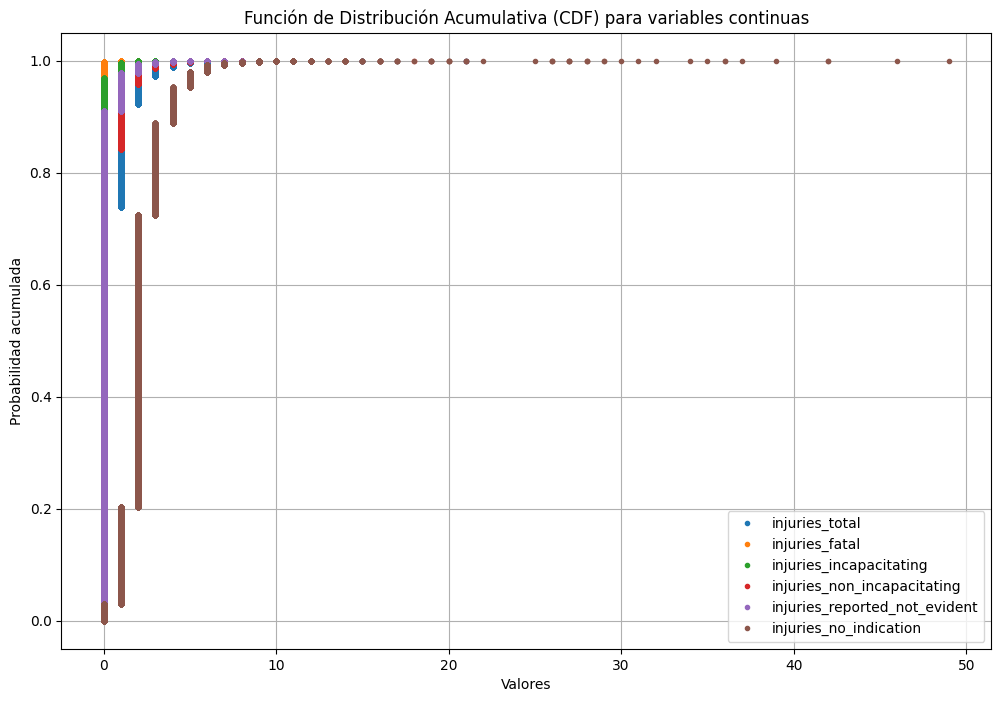

In [132]:
#CDF para variables continuas

import numpy as np

def plot_cdf_continuous(data, columns):
    plt.figure(figsize=(12, 8))
    
    for column in columns:
        sorted_data = np.sort(data[column].dropna())  # Ordenar datos y eliminar nulos
        cdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)  # Calcular CDF
        
        plt.plot(sorted_data, cdf, marker=".", linestyle="none", label=column)
    
    plt.xlabel("Valores")
    plt.ylabel("Probabilidad acumulada")
    plt.title("Función de Distribución Acumulativa (CDF) para variables continuas")
    plt.legend()
    plt.grid(True)
    plt.show()

# Lista de variables continuas
continuous_vars = [
    "injuries_total", "injuries_fatal", "injuries_incapacitating", 
    "injuries_non_incapacitating", "injuries_reported_not_evident", "injuries_no_indication"
]


plot_cdf_continuous(data, continuous_vars)

Esto muestra que la mayoría de los accidentes reportan un número reducido de lesiones en todas las categorías. injuries_total (azul) se acumula rápidamente en valores bajos, indicando que es poco común encontrar más de 5 lesionados en un accidente. injuries_fatal (naranja) presenta una acumulación tardía, confirmando que los accidentes con víctimas fatales son raros. Tanto injuries_incapacitating (verde) como injuries_non_incapacitating (rojo) muestran que la mayoría de los casos presentan solo unas pocas lesiones graves o moderadas, con valores superiores a 2 y 5 respectivamente siendo poco frecuentes. injuries_reported_not_evident (morado) también crece rápido, sugiriendo que la mayoría de los accidentes con lesiones reportadas sin evidencia afectan a pocos individuos. Finalmente, injuries_no_indication (café) es la variable con mayor acumulación inicial, indicando que en la mayoría de los accidentes no se reportan lesiones, lo que podría estar relacionado con medidas de seguridad vehicular o reportes preventivos sin consecuencias graves.

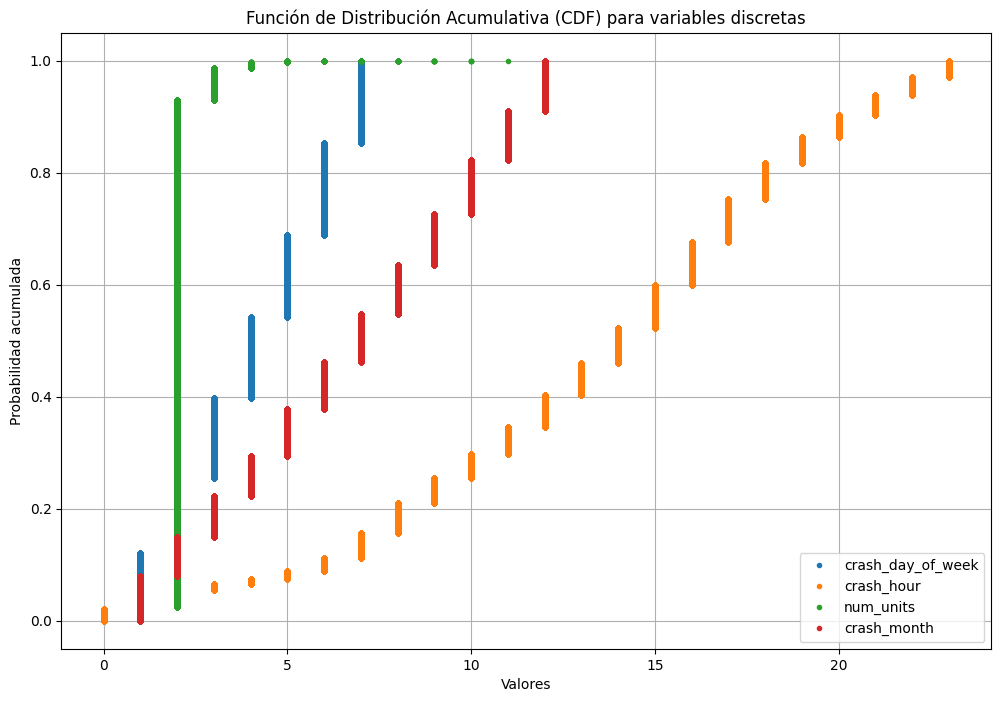

In [133]:
# CDF con variables discretas

def plot_cdf(data, columns):
    plt.figure(figsize=(12, 8))
    
    for column in columns:
        sorted_data = np.sort(data[column].dropna())  # Ordenar datos y eliminar nulos
        cdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)  # Calcular CDF
        
        plt.plot(sorted_data, cdf, marker=".", linestyle="none", label=column)
    
    plt.xlabel("Valores")
    plt.ylabel("Probabilidad acumulada")
    plt.title("Función de Distribución Acumulativa (CDF) para variables discretas")
    plt.legend()
    plt.grid(True)
    plt.show()

# Lista de variables discretas
discrete_vars = ["crash_day_of_week", "crash_hour", "num_units", "crash_month"]

plot_cdf(data, discrete_vars)

La anterior gráfica, muestra cómo se distribuyen las variables discretas en los accidentes de tráfico, evidenciando patrones en la ocurrencia de accidentes según el día de la semana, la hora del accidente, el número de unidades involucradas y el mes del año. Se observa que la variable num_units (verde) alcanza rápidamente su máximo, lo que indica que la mayoría de los accidentes involucran pocos vehículos. La variable crash_day_of_week (azul) presenta una progresión escalonada, sugiriendo una distribución relativamente uniforme a lo largo de la semana. En contraste, crash_hour (naranja) y crash_month (rojo) muestran una acumulación más gradual, lo que sugiere una mayor variabilidad en la hora y el mes en que ocurren los accidentes. 

#### Medidas de tendencia central

#### 1.Mediana

In [134]:
medianas = data.median(numeric_only=True)  # Calcula la mediana solo para columnas numéricas
print(medianas)

num_units                         2.0
injuries_total                    0.0
injuries_fatal                    0.0
injuries_incapacitating           0.0
injuries_non_incapacitating       0.0
injuries_reported_not_evident     0.0
injuries_no_indication            2.0
crash_hour                       14.0
crash_day_of_week                 4.0
crash_month                       7.0
dtype: float64


/tmp/ipykernel_2192/42209750.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=medianas.index, y=medianas.values, palette="viridis")


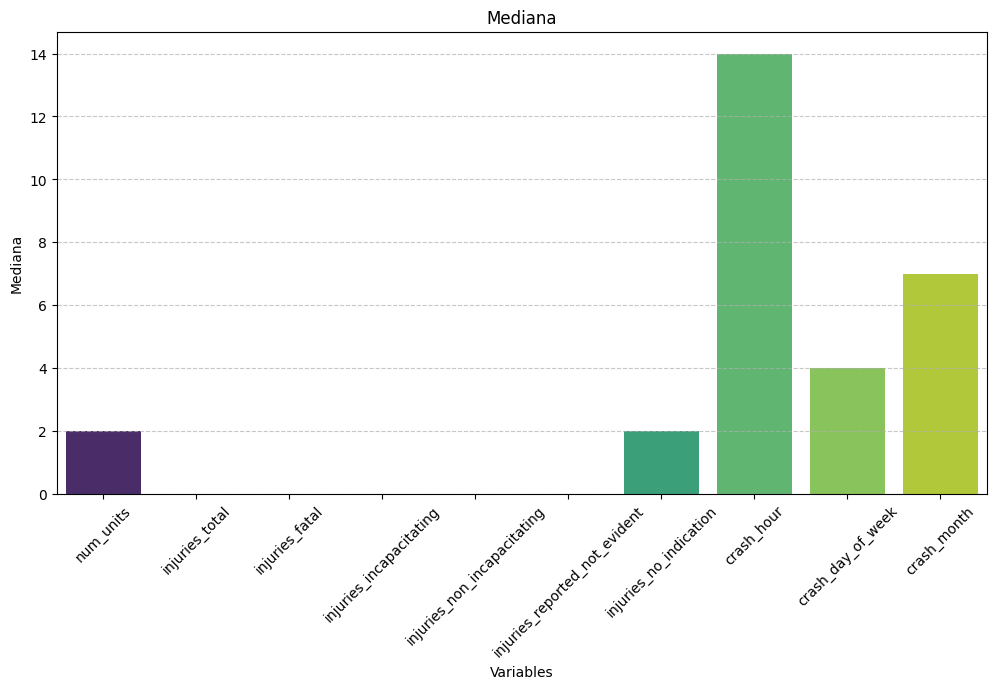

In [135]:
plt.figure(figsize=(12, 6))
sns.barplot(x=medianas.index, y=medianas.values, palette="viridis")

plt.xlabel("Variables")
plt.ylabel("Mediana")
plt.title("Mediana")# para variables númericas
plt.xticks(rotation=45)  # rotar etiquetas para mejor visualización
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()

 En este caso, la mediana de num_units es 2, lo que sugiere que en la mayoría de los accidentes estuvieron involucradas dos unidades. Para las variables de lesiones (injuries_total, injuries_fatal, injuries_incapacitating, injuries_non_incapacitating, injuries_reported_not_evident), la mediana es 0, lo que indica que en más de la mitad de los accidentes no se reportaron lesiones. Injuries_no_indication tiene una mediana de 2, lo que podría sugerir que la mayoría de los registros indican la ausencia de lesiones. En cuanto a crash_hour, la mediana es 14, lo que sugiere que la mayor parte de los accidentes ocurren alrededor de las 2 p.m. La mediana de crash_day_of_week es 4, lo que corresponde al jueves, y crash_month tiene una mediana de 7, indicando que julio es el mes central en la distribución de accidentes.

#### 2.Moda

In [136]:
modas = data.mode(numeric_only=True).iloc[0]  # Extraemos la primera moda si hay varias

print(modas)

num_units                         2.0
injuries_total                    0.0
injuries_fatal                    0.0
injuries_incapacitating           0.0
injuries_non_incapacitating       0.0
injuries_reported_not_evident     0.0
injuries_no_indication            2.0
crash_hour                       17.0
crash_day_of_week                 6.0
crash_month                      10.0
Name: 0, dtype: float64


/tmp/ipykernel_2192/2594931549.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=modas.index, y=modas.values, palette="magma")


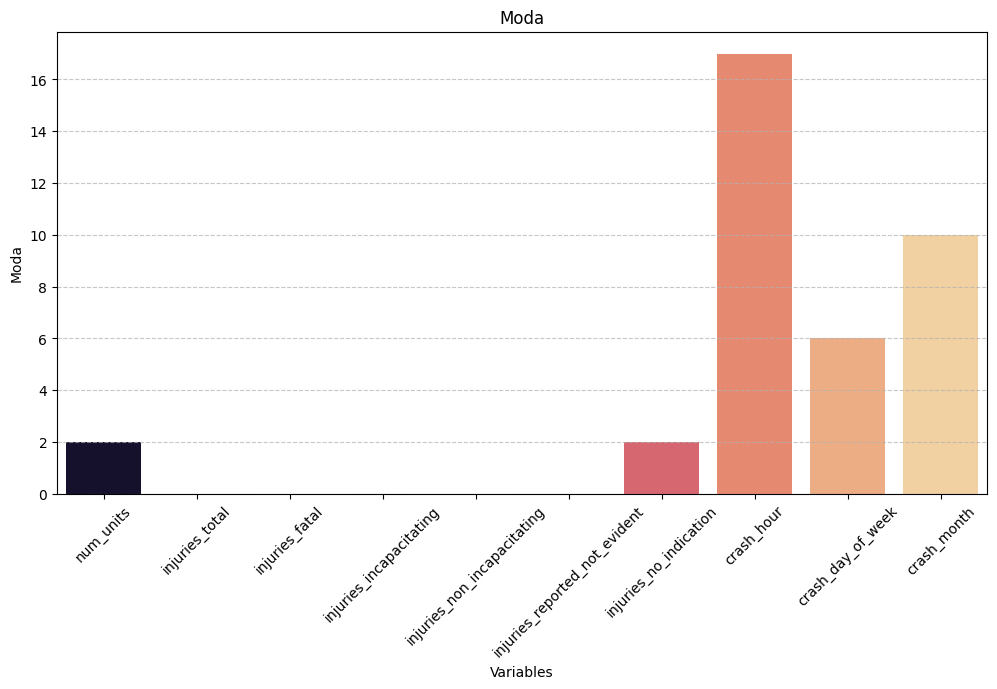

In [137]:
plt.figure(figsize=(12, 6))
sns.barplot(x=modas.index, y=modas.values, palette="magma")

plt.xlabel("Variables")
plt.ylabel("Moda") #para variables númericas
plt.title("Moda")
plt.xticks(rotation=45)  # Rotar etiquetas para mejor visualización
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()

En este caso, observamos que la mayoría de las variables relacionadas con lesiones (injuries_total, injuries_fatal, injuries_incapacitating, injuries_non_incapacitating, injuries_reported_not_evident) tienen una moda de 0, lo que indica que la mayoría de los accidentes no presentan lesiones. Para num_units, la moda es 2, lo que sugiere que la mayoría de los accidentes involucran dos vehículos. En cuanto a la hora del accidente (crash_hour), el valor más frecuente es 17, lo que indica que la mayoría de los accidentes ocurren a las 5:00 p.m., probablemente debido al tráfico de la hora pico. Para el día de la semana (crash_day_of_week), la moda es 6, lo que sugiere que el sábado es el día con más accidentes. Finalmente, la moda de crash_month es 10, indicando que octubre es el mes con mayor número de accidentes reportados.

#### 3.Media

In [138]:
media = data.mean(numeric_only=True)

print("Media de las variables:")
print(media)

Media de las variables:
num_units                         2.063300
injuries_total                    0.382717
injuries_fatal                    0.001859
injuries_incapacitating           0.038102
injuries_non_incapacitating       0.221241
injuries_reported_not_evident     0.121516
injuries_no_indication            2.244002
crash_hour                       13.373047
crash_day_of_week                 4.144024
crash_month                       6.771822
dtype: float64


/tmp/ipykernel_2192/936230892.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=media.index, y=media.values, palette="viridis")


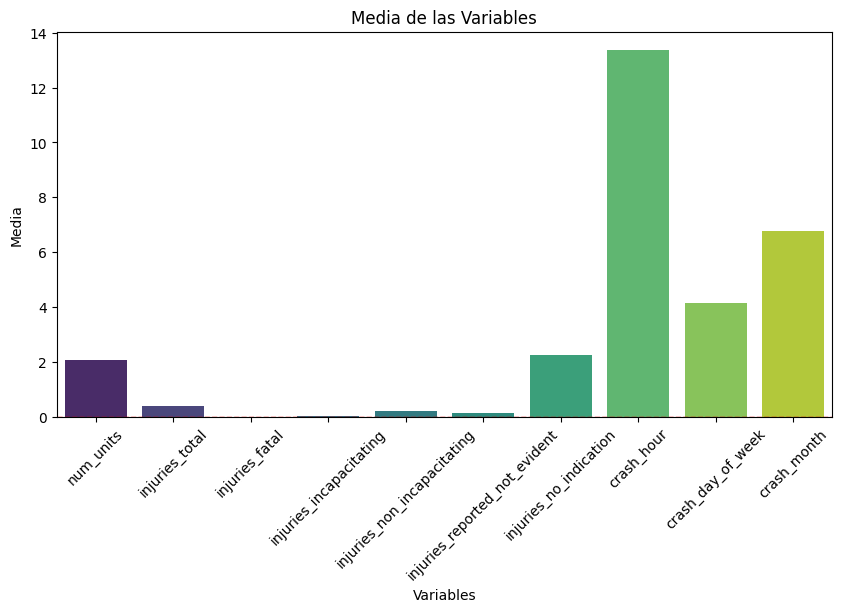

In [139]:
plt.figure(figsize=(10, 5))
sns.barplot(x=media.index, y=media.values, palette="viridis")

plt.xticks(rotation=45)
plt.axhline(y=0, color='r', linestyle='dashed', linewidth=1)  # Línea en 0
plt.xlabel("Variables")
plt.ylabel("Media")
plt.title("Media de las Variables")

plt.show()

Num_units (4.73) indica que en promedio, hay alrededor de 5 vehículos involucrados en un accidente. Injuries_total (2.89) sugiere que los accidentes generan en promedio casi 3 lesionados. Crash_hour (11.77) muestra que la mayoría de los accidentes ocurren entre las 11 a. m. y 12 p. m., lo que podría estar relacionado con el tráfico del mediodía. Crash_day_of_week (4.05) implica que los accidentes ocurren con mayor frecuencia alrededor del jueves (considerando que los días de la semana están representados numéricamente). Finalmente, crash_month (5.79) indica que los accidentes son más frecuentes a mediados de año, en mayo o junio.

#### Medidas de dispersión

#### 1.Rango

In [140]:
# Calcular el rango (máximo - mínimo)
rango = data.max(numeric_only=True) - data.min(numeric_only=True)

print(rango)

num_units                        10.0
injuries_total                   21.0
injuries_fatal                    3.0
injuries_incapacitating           7.0
injuries_non_incapacitating      21.0
injuries_reported_not_evident    15.0
injuries_no_indication           49.0
crash_hour                       23.0
crash_day_of_week                 6.0
crash_month                      11.0
dtype: float64


/tmp/ipykernel_2192/2335052676.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=rango.index, y=rango.values, palette="viridis")


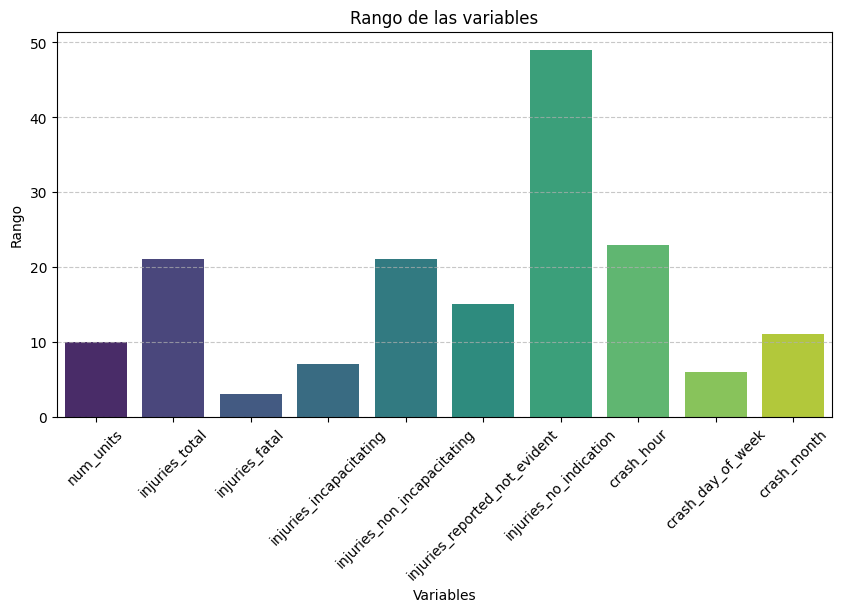

In [141]:
plt.figure(figsize=(10, 5))
sns.barplot(x=rango.index, y=rango.values, palette="viridis")

plt.xticks(rotation=45)
plt.xlabel("Variables")
plt.ylabel("Rango")
plt.title("Rango de las variables")
plt.grid(axis="y", linestyle="--", alpha=0.7)


plt.show()

Lo anterior nos muestra la dispersión de cada variable en el conjunto de datos. injuries_no_indication tiene el rango más alto (49), lo que indica una gran variabilidad en la cantidad de accidentes sin indicios de lesiones. injuries_total y injuries_reported_not_evident también presentan una dispersión considerable (21 y 15, respectivamente), lo que sugiere que algunos accidentes tienen muchas lesiones mientras que otros no tienen ninguna. crash_hour tiene un rango de 23, lo cual es esperable, ya que las horas del día van de 0 a 23. crash_day_of_week y crash_month tienen una variabilidad más baja, con rangos de 6 y 11 respectivamente, lo que refleja la naturaleza estructurada de los días de la semana y los meses del año. En general, la variabilidad en las lesiones es alta en comparación con la de las variables temporales.

#### 2.Varianza y desviación estándar

In [142]:
varianza = data.var(numeric_only=True)
print("Varianza:\n", varianza)

# Calcular la desviación estándar
desviacion_estandar = data.std(numeric_only=True)
print("\nDesviación Estándar:\n", desviacion_estandar)

Varianza:
 num_units                         0.156825
injuries_total                    0.639552
injuries_fatal                    0.002256
injuries_incapacitating           0.054739
injuries_non_incapacitating       0.378175
injuries_reported_not_evident     0.203279
injuries_no_indication            1.540515
crash_hour                       31.402915
crash_day_of_week                 3.868553
crash_month                      11.748393
dtype: float64

Desviación Estándar:
 num_units                        0.396012
injuries_total                   0.799720
injuries_fatal                   0.047502
injuries_incapacitating          0.233964
injuries_non_incapacitating      0.614960
injuries_reported_not_evident    0.450865
injuries_no_indication           1.241175
crash_hour                       5.603830
crash_day_of_week                1.966864
crash_month                      3.427593
dtype: float64


/tmp/ipykernel_2192/1218831138.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(varianza.index, rotation=45, ha="right")
/tmp/ipykernel_2192/1218831138.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(desviacion_estandar.index, rotation=45, ha="right")


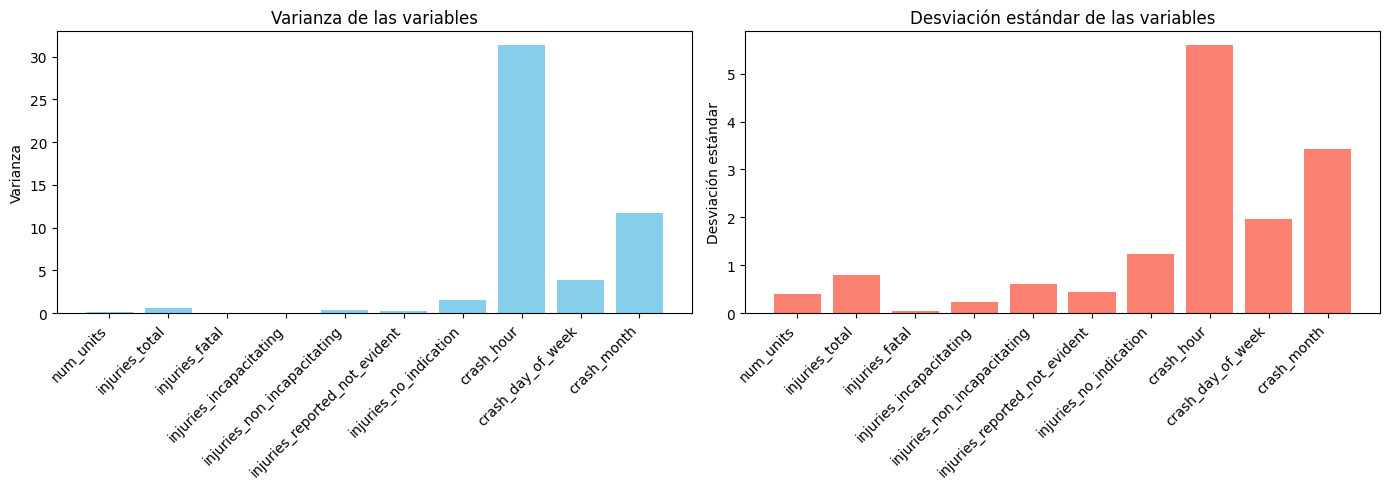

In [143]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Gráfico de varianza
axes[0].bar(varianza.index, varianza, color='skyblue')
axes[0].set_title("Varianza de las variables")
axes[0].set_xticklabels(varianza.index, rotation=45, ha="right")
axes[0].set_ylabel("Varianza")

# Gráfico de desviación estándar
axes[1].bar(desviacion_estandar.index, desviacion_estandar, color='salmon')
axes[1].set_title("Desviación estándar de las variables")
axes[1].set_xticklabels(desviacion_estandar.index, rotation=45, ha="right")
axes[1].set_ylabel("Desviación estándar")

plt.tight_layout()
plt.show()

Los resultados muestran que la mayor variabilidad se encuentra en crash_hour (31.40 de varianza, 5.06 de desviación estándar), crash_month (11.75, 3.43) y crash_day_of_week (3.87, 1.97), lo que indica que los accidentes ocurren en un amplio rango de horarios y fechas. En cuanto a las lesiones, injuries_total (0.64, 0.80) y injuries_no_indication (1.54, 1.24) presentan una mayor dispersión, lo que sugiere diferencias en la cantidad de lesiones por accidente. En contraste, injuries_fatal (0.002, 0.047) tiene una dispersión mínima, lo que indica que el número de víctimas fatales es generalmente bajo y constante. injuries_incapacitating (0.047, 0.23), injuries_non_incapacitating (0.38, 0.61) e injuries_reported_not_evident (0.20, 0.45) también presentan baja variabilidad, reflejando que la mayoría de los accidentes tienen una cantidad similar de lesiones. Finalmente, num_units (0.16, 0.40) sugiere que la cantidad de vehículos involucrados en los accidentes no varía drásticamente. 

En general, los accidentes muestran más variabilidad en el tiempo y en la cantidad de lesiones leves que en el número de vehículos o víctimas fatales.

#### Medidas de posición

#### 1.Percentiles y cuantiles

In [144]:
percentiles = data.quantile([0, 0.25, 0.5, 0.75, 1], numeric_only=True)

print(percentiles)

      num_units  injuries_total  injuries_fatal  injuries_incapacitating  \
0.00        1.0             0.0             0.0                      0.0   
0.25        2.0             0.0             0.0                      0.0   
0.50        2.0             0.0             0.0                      0.0   
0.75        2.0             1.0             0.0                      0.0   
1.00       11.0            21.0             3.0                      7.0   

      injuries_non_incapacitating  injuries_reported_not_evident  \
0.00                          0.0                            0.0   
0.25                          0.0                            0.0   
0.50                          0.0                            0.0   
0.75                          0.0                            0.0   
1.00                         21.0                           15.0   

      injuries_no_indication  crash_hour  crash_day_of_week  crash_month  
0.00                     0.0         0.0                1.0

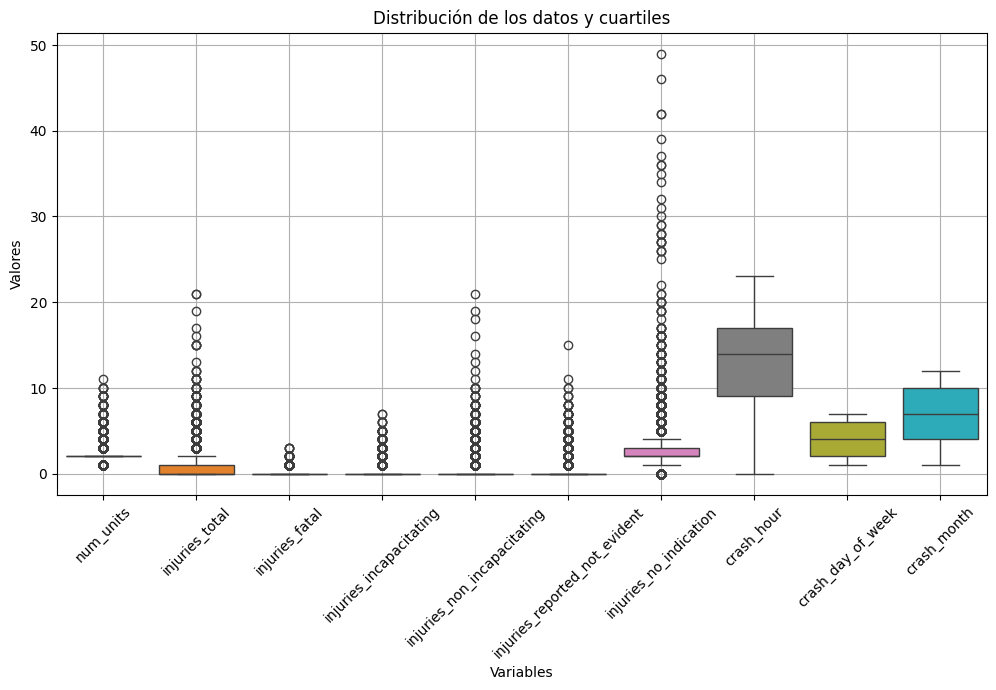

In [145]:
plt.figure(figsize=(12, 6))

# Crear un boxplot para visualizar cuartiles
sns.boxplot(data=data.select_dtypes(include=['number']))

plt.xticks(rotation=45)  # Rotar etiquetas del eje X para mejor visibilidad
plt.title("Distribución de los datos y cuartiles")
plt.xlabel("Variables")
plt.ylabel("Valores")
plt.grid(True)

plt.show()

La variable num_units muestra un rango estrecho, con un valor mediano de 2 unidades involucradas en los accidentes, aunque algunos casos alcanzan hasta 11 unidades. En cuanto a injuries_total, la mayoría de los accidentes no reportan lesiones, reflejando valores bajos en los cuartiles inferiores, pero con casos atípicos que llegan hasta 21 lesiones. Las lesiones fatales (injuries_fatal) son poco frecuentes, con valores de 0 en todos los cuartiles excepto en el máximo, donde se observan hasta 3 casos. De manera similar, injuries_incapacitating y injuries_non_incapacitating presentan valores concentrados en 0, indicando que la mayoría de los accidentes no resultan en lesiones graves, aunque existen eventos aislados con hasta 7 y 21 casos, respectivamente.

Las lesiones no evidentes (injuries_reported_not_evident) y los accidentes sin indicación de lesiones (injuries_no_indication) también presentan una distribución sesgada hacia valores bajos, con una alta frecuencia de reportes sin lesiones (percentil 50 en 0 o 2), pero con valores máximos de hasta 15 y 49 respectivamente, lo que indica que algunos accidentes presentan un gran número de reportes. La variable crash_hour muestra una mediana de 14 horas, indicando que la mayoría de los accidentes ocurren alrededor de esa hora, aunque hay una amplia dispersión con valores desde 0 hasta 23 horas, reflejando la ocurrencia de accidentes en diferentes momentos del día, es decir, esto sugiere que algunos accidentes presentan una alta cantidad de incidentes reportados sin indicación de lesiones y que la hora de ocurrencia varía significativamente.

Por otro lado, crash_day_of_week tiene un comportamiento relativamente uniforme con una mediana en 4, sugiriendo que los accidentes ocurren con mayor frecuencia entre miércoles y jueves, aunque el percentil máximo muestra casos hasta el séptimo día (domingo). Finalmente, crash_month revela que la mayoría de los accidentes se concentran en el segundo y tercer cuartil entre abril y octubre (percentil 50 en 7), con valores que van desde enero (1) hasta diciembre (12), indicando que los accidentes pueden ocurrir en cualquier época del año pero con ciertas temporadas de mayor incidencia. 

#### Medidas de forma

#### 1.Oblicuidad

In [146]:
from scipy.stats import skew

# Calcular la oblicuidad para cada variable numérica
oblicuidad = data.skew(numeric_only=True)

print("Oblicuidad de las variables:")
print(oblicuidad)

Oblicuidad de las variables:
num_units                         3.988290
injuries_total                    3.414446
injuries_fatal                   29.525440
injuries_incapacitating           8.443042
injuries_non_incapacitating       4.535004
injuries_reported_not_evident     5.446189
injuries_no_indication            3.742787
crash_hour                       -0.435483
crash_day_of_week                -0.094235
crash_month                      -0.122531
dtype: float64


/tmp/ipykernel_2192/3587681457.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=oblicuidad.index, y=oblicuidad.values, palette="coolwarm")


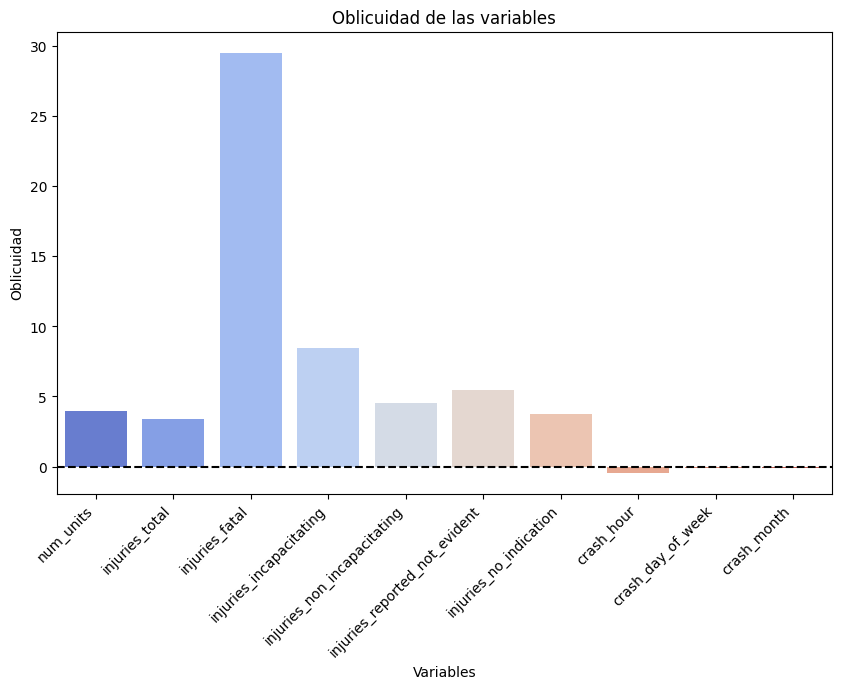

In [147]:
plt.figure(figsize=(10, 6))

sns.barplot(x=oblicuidad.index, y=oblicuidad.values, palette="coolwarm")

plt.xticks(rotation=45, ha='right')
plt.xlabel("Variables")
plt.ylabel("Oblicuidad")
plt.title("Oblicuidad de las variables")
plt.axhline(0, color='black', linestyle='--')# Mostrar la línea en 0 para referencia

plt.show()

La oblicuidad (sesgo) de los datos indica qué tan simétrica es su distribución. En este caso, variables como injuries_fatal (29.52), injuries_incapacitating (8.43),injuries_non_incapacitating (4.53) e injuries_reported_not_evident (5.45) presentan un fuerte sesgo positivo, lo que sugiere que la mayoría de los valores son bajos, pero hay algunos valores extremadamente altos que arrastran la media. Por otro lado, crash_hour (-0.43), crash_day_of_week (-0.49) y crash_month (-0.12) tienen un sesgo negativo leve, lo que indica una ligera concentración de valores más altos con colas a la izquierda. Finalmente, num_units (3.99) e injuries_total (3.41) también presentan sesgo positivo moderado, reflejando la presencia de eventos con múltiples unidades o lesiones más graves, aunque la mayoría de los casos siguen concentrándose en valores más bajos. 

#### 2.Curtosis

In [148]:
print(type(data))

<class 'pandas.core.frame.DataFrame'>


In [149]:
data = pd.DataFrame(data)

In [150]:
from scipy.stats import kurtosis  

# Calcular la curtosis para cada variable numérica
curtosis = data.apply(lambda x: kurtosis(x, nan_policy="omit") if x.dtype in ['int64', 'float64'] else None)

print("Curtosis de las variables:")
print(curtosis)


Curtosis de las variables:
crash_date                               NaN
traffic_control_device                   NaN
weather_condition                        NaN
lighting_condition                       NaN
first_crash_type                         NaN
trafficway_type                          NaN
alignment                                NaN
roadway_surface_cond                     NaN
road_defect                              NaN
crash_type                               NaN
intersection_related_i                   NaN
damage                                   NaN
prim_contributory_cause                  NaN
num_units                          35.765532
most_severe_injury                       NaN
injuries_total                     23.184144
injuries_fatal                   1044.316508
injuries_incapacitating           101.497541
injuries_non_incapacitating        41.052415
injuries_reported_not_evident      46.984979
injuries_no_indication             65.914278
crash_hour                  

/tmp/ipykernel_2192/2845622998.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=curtosis.index, y=curtosis.values, palette="viridis")


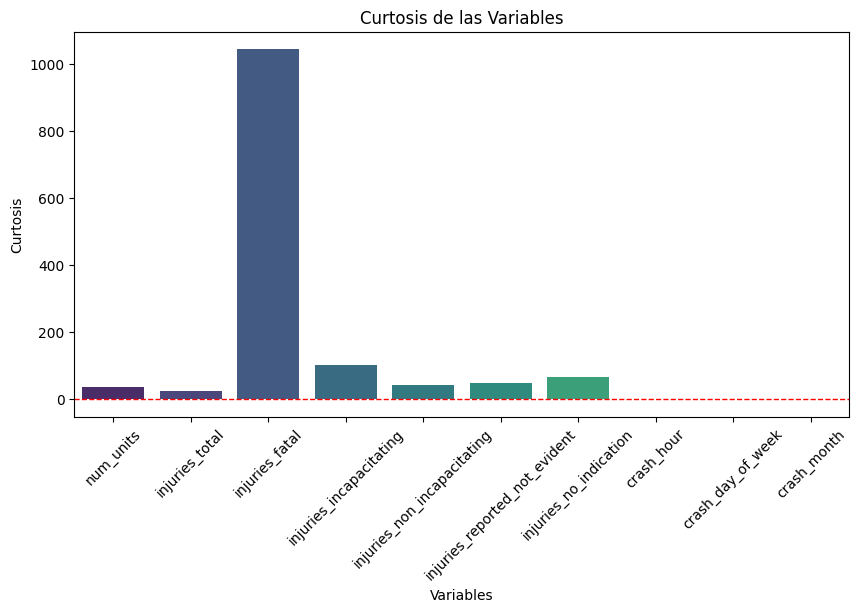

In [151]:
# Filtrar solo las columnas numéricas
curtosis = curtosis.dropna()

plt.figure(figsize=(10, 5))
sns.barplot(x=curtosis.index, y=curtosis.values, palette="viridis")

plt.xlabel("Variables")
plt.ylabel("Curtosis")
plt.title("Curtosis de las Variables")
plt.xticks(rotation=45)  # Rotar etiquetas si hay muchas variables
plt.axhline(y=0, color="red", linestyle="--", linewidth=1)  # Línea en y=0 para referencia

plt.show()

La variable injuries_total presenta una alta curtosis (6.044), indicando una distribución leptocúrtica con valores extremos, es decir, algunos accidentes tienen muchas más lesiones que el promedio. En contraste, num_units (0.249) muestra una distribución aproximadamente normal, sin valores extremos significativos. Por otro lado, crash_hour (-0.257), crash_day_of_week (-1.427) y crash_month (-1.312) tienen curtosis negativa, lo que sugiere distribuciones platicúrticas, más dispersas y sin grandes concentraciones de valores en los extremos. Esto indica que los accidentes ocurren de manera relativamente uniforme en el tiempo, sin fuertes picos o valores atípicos en días, meses u horas específicas.

### Step 5: Perform a full EDA

In [152]:
# Obtain dimensions
data.shape

(209306, 24)

El dataset contiene un total de 209306 registros cuyos atributos se distribuyen en 24 columnas

In [153]:
# Obtain information about data types and non-null values
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209306 entries, 0 to 209305
Data columns (total 24 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   crash_date                     209306 non-null  object 
 1   traffic_control_device         209306 non-null  object 
 2   weather_condition              209306 non-null  object 
 3   lighting_condition             209306 non-null  object 
 4   first_crash_type               209306 non-null  object 
 5   trafficway_type                209306 non-null  object 
 6   alignment                      209306 non-null  object 
 7   roadway_surface_cond           209306 non-null  object 
 8   road_defect                    209306 non-null  object 
 9   crash_type                     209306 non-null  object 
 10  intersection_related_i         209306 non-null  object 
 11  damage                         209306 non-null  object 
 12  prim_contributory_cause       

- Hay un total de 209306 registros
- 10 variables son de tipo numérico, y 14 son categóricas.
- No se detectó ningún registro con columnas nulas.


In [154]:
if data.duplicated().sum():
    print("Duplicados encontrados: ",data.duplicated().sum())
    total_data = data.drop_duplicates()
print(total_data.shape)
total_data.head()

Duplicados encontrados:  31
(209275, 24)


,crash_date,traffic_control_device,weather_condition,lighting_condition,first_crash_type,trafficway_type,alignment,roadway_surface_cond,road_defect,crash_type,...,most_severe_injury,injuries_total,injuries_fatal,injuries_incapacitating,injuries_non_incapacitating,injuries_reported_not_evident,injuries_no_indication,crash_hour,crash_day_of_week,crash_month
0,07/29/2023 01:00:00 PM,TRAFFIC SIGNAL,CLEAR,DAYLIGHT,TURNING,NOT DIVIDED,STRAIGHT AND LEVEL,UNKNOWN,UNKNOWN,NO INJURY / DRIVE AWAY,...,NO INDICATION OF INJURY,0.0,0.0,0.0,0.0,0.0,3.0,13,7,7
1,08/13/2023 12:11:00 AM,TRAFFIC SIGNAL,CLEAR,"DARKNESS, LIGHTED ROAD",TURNING,FOUR WAY,STRAIGHT AND LEVEL,DRY,NO DEFECTS,NO INJURY / DRIVE AWAY,...,NO INDICATION OF INJURY,0.0,0.0,0.0,0.0,0.0,2.0,0,1,8
2,12/09/2021 10:30:00 AM,TRAFFIC SIGNAL,CLEAR,DAYLIGHT,REAR END,T-INTERSECTION,STRAIGHT AND LEVEL,DRY,NO DEFECTS,NO INJURY / DRIVE AWAY,...,NO INDICATION OF INJURY,0.0,0.0,0.0,0.0,0.0,3.0,10,5,12
3,08/09/2023 07:55:00 PM,TRAFFIC SIGNAL,CLEAR,DAYLIGHT,ANGLE,FOUR WAY,STRAIGHT AND LEVEL,DRY,NO DEFECTS,INJURY AND / OR TOW DUE TO CRASH,...,NONINCAPACITATING INJURY,5.0,0.0,0.0,5.0,0.0,0.0,19,4,8
4,08/19/2023 02:55:00 PM,TRAFFIC SIGNAL,CLEAR,DAYLIGHT,REAR END,T-INTERSECTION,STRAIGHT AND LEVEL,UNKNOWN,UNKNOWN,NO INJURY / DRIVE AWAY,...,NO INDICATION OF INJURY,0.0,0.0,0.0,0.0,0.0,3.0,14,7,8


In [155]:
data.drop(["crash_date", "first_crash_type", "damage", "injuries_total"], axis = 1, inplace = True)
data.head()

,traffic_control_device,weather_condition,lighting_condition,trafficway_type,alignment,roadway_surface_cond,road_defect,crash_type,intersection_related_i,prim_contributory_cause,num_units,most_severe_injury,injuries_fatal,injuries_incapacitating,injuries_non_incapacitating,injuries_reported_not_evident,injuries_no_indication,crash_hour,crash_day_of_week,crash_month
0,TRAFFIC SIGNAL,CLEAR,DAYLIGHT,NOT DIVIDED,STRAIGHT AND LEVEL,UNKNOWN,UNKNOWN,NO INJURY / DRIVE AWAY,Y,UNABLE TO DETERMINE,2,NO INDICATION OF INJURY,0.0,0.0,0.0,0.0,3.0,13,7,7
1,TRAFFIC SIGNAL,CLEAR,"DARKNESS, LIGHTED ROAD",FOUR WAY,STRAIGHT AND LEVEL,DRY,NO DEFECTS,NO INJURY / DRIVE AWAY,Y,IMPROPER TURNING/NO SIGNAL,2,NO INDICATION OF INJURY,0.0,0.0,0.0,0.0,2.0,0,1,8
2,TRAFFIC SIGNAL,CLEAR,DAYLIGHT,T-INTERSECTION,STRAIGHT AND LEVEL,DRY,NO DEFECTS,NO INJURY / DRIVE AWAY,Y,FOLLOWING TOO CLOSELY,3,NO INDICATION OF INJURY,0.0,0.0,0.0,0.0,3.0,10,5,12
3,TRAFFIC SIGNAL,CLEAR,DAYLIGHT,FOUR WAY,STRAIGHT AND LEVEL,DRY,NO DEFECTS,INJURY AND / OR TOW DUE TO CRASH,Y,UNABLE TO DETERMINE,2,NONINCAPACITATING INJURY,0.0,0.0,5.0,0.0,0.0,19,4,8
4,TRAFFIC SIGNAL,CLEAR,DAYLIGHT,T-INTERSECTION,STRAIGHT AND LEVEL,UNKNOWN,UNKNOWN,NO INJURY / DRIVE AWAY,Y,DRIVING SKILLS/KNOWLEDGE/EXPERIENCE,2,NO INDICATION OF INJURY,0.0,0.0,0.0,0.0,3.0,14,7,8


In [156]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209306 entries, 0 to 209305
Data columns (total 20 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   traffic_control_device         209306 non-null  object 
 1   weather_condition              209306 non-null  object 
 2   lighting_condition             209306 non-null  object 
 3   trafficway_type                209306 non-null  object 
 4   alignment                      209306 non-null  object 
 5   roadway_surface_cond           209306 non-null  object 
 6   road_defect                    209306 non-null  object 
 7   crash_type                     209306 non-null  object 
 8   intersection_related_i         209306 non-null  object 
 9   prim_contributory_cause        209306 non-null  object 
 10  num_units                      209306 non-null  int64  
 11  most_severe_injury             209306 non-null  object 
 12  injuries_fatal                

- Hay un total de 209306 cuyos atributos se encuentran distribuidos en 20 columnas.
- 9 variables se consideran numéricas debido a que sus atributos sirven para contabilizar.
- 11 variables son categóricas.

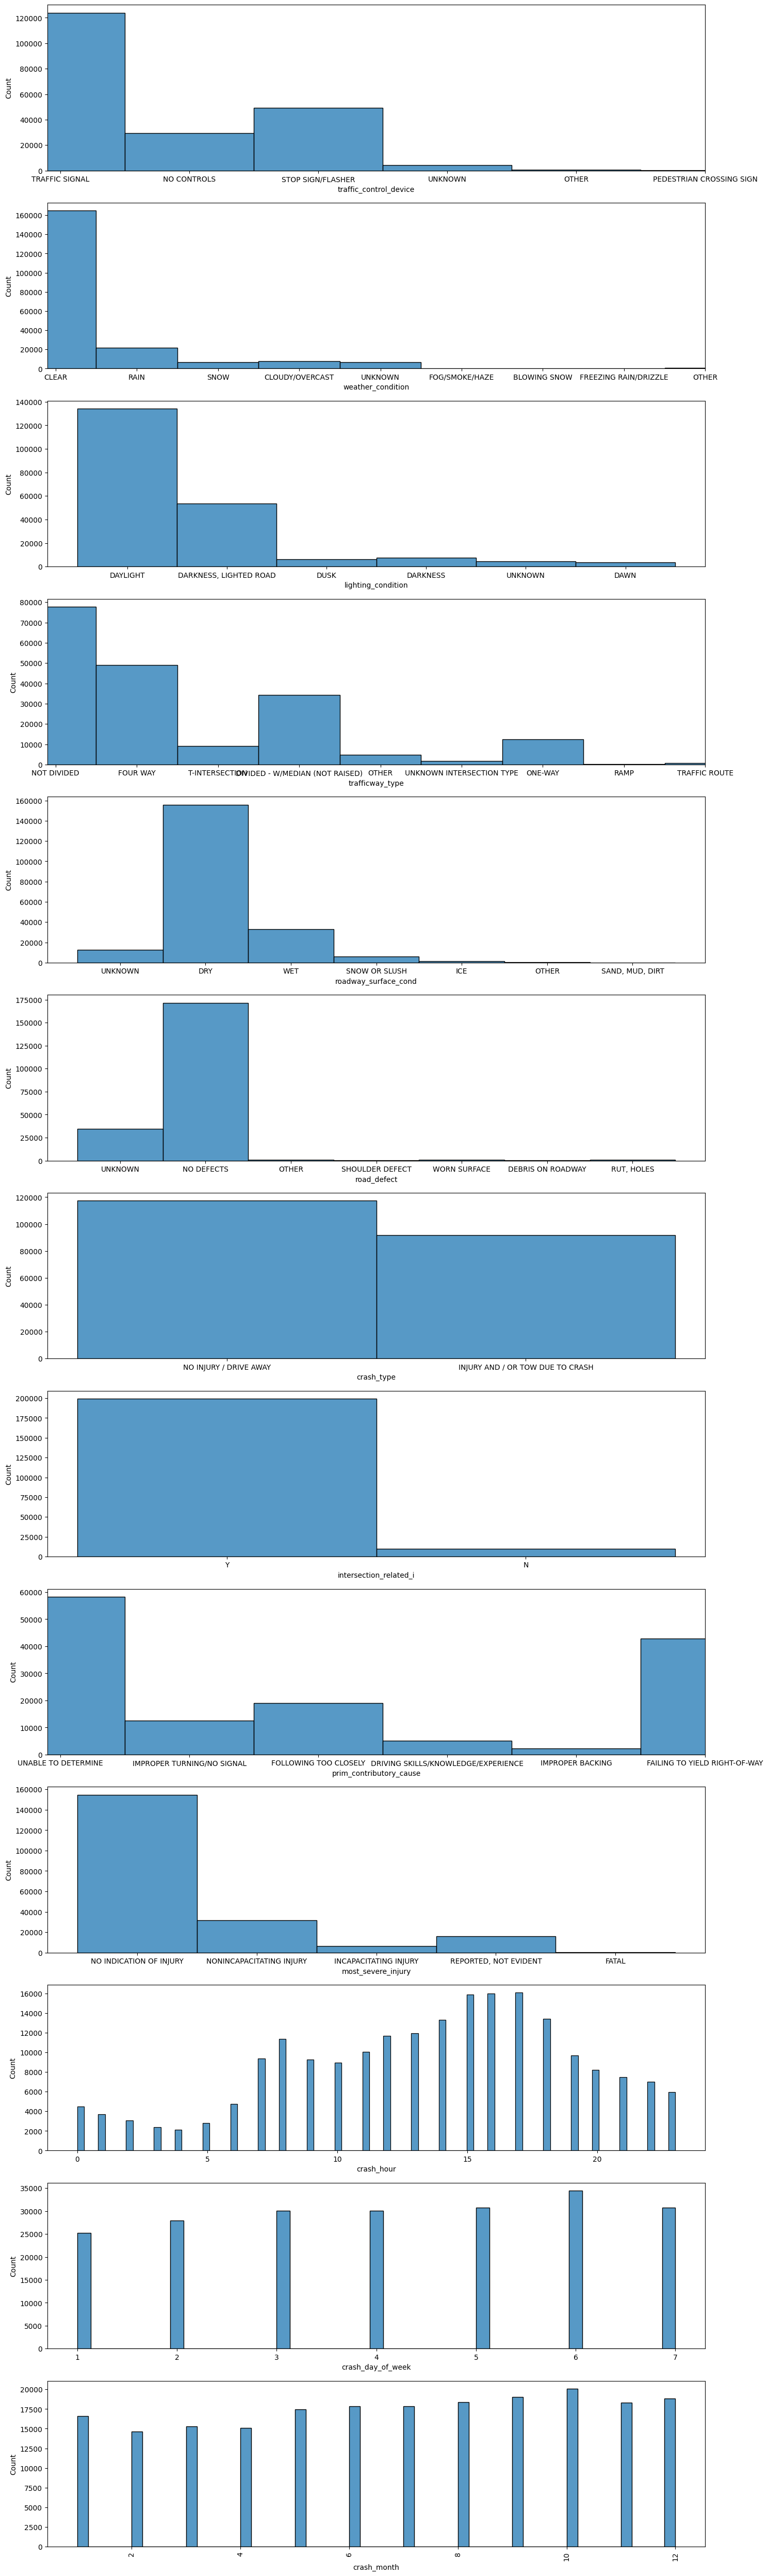

In [157]:
import matplotlib.pyplot as plt 
import seaborn as sns

fig, axis = plt.subplots(13, figsize = (15, 50))

# Create a multiple histogram
sns.histplot(ax = axis[0], data = data, x = "traffic_control_device").set_xlim(-0.1, 5)
sns.histplot(ax = axis[1], data = data, x = "weather_condition").set_xlim(-0.1, 8)
sns.histplot(ax = axis[2], data = data, x = "lighting_condition")
sns.histplot(ax = axis[3], data = data, x = "trafficway_type").set_xlim(-0.1, 8)
sns.histplot(ax = axis[4], data = data, x = "roadway_surface_cond")
sns.histplot(ax = axis[5], data = data, x = "road_defect")
sns.histplot(ax = axis[6], data = data, x = "crash_type")
sns.histplot(ax = axis[7], data = data, x = "intersection_related_i")
sns.histplot(ax = axis[8], data = data, x = "prim_contributory_cause").set_xlim(-0.1, 5)
sns.histplot(ax = axis[9], data = data, x = "most_severe_injury")
sns.histplot(ax = axis[10], data = data, x = "crash_hour")
sns.histplot(ax = axis[11], data = data, x = "crash_day_of_week")
sns.histplot(ax = axis[12], data = data, x = "crash_month")


# Adjust the layout
plt.tight_layout()
plt.xticks(rotation=90)

# Show the plot
plt.show()

- Cuando las condiciones climáticas y de carretera son optimas, el riesgo de accidente vial aumenta debido al factor humano de forma significativa.
- Existen más accidentes de tráfico en vialidades donde hay semáforos
- La mayoría de los accidentes es causado por factores humanos, tal como se concluyó anteriormente
- No hubieron heridos reportados en la mayor parte de los accidentes registrados.
- De 3 a 5 pm existe una mayor probabilidad de que ocurra un accidente
- Los viernes son más propensos a accidentes
- Octubre es el mes con el mayor número de accidentes registrados

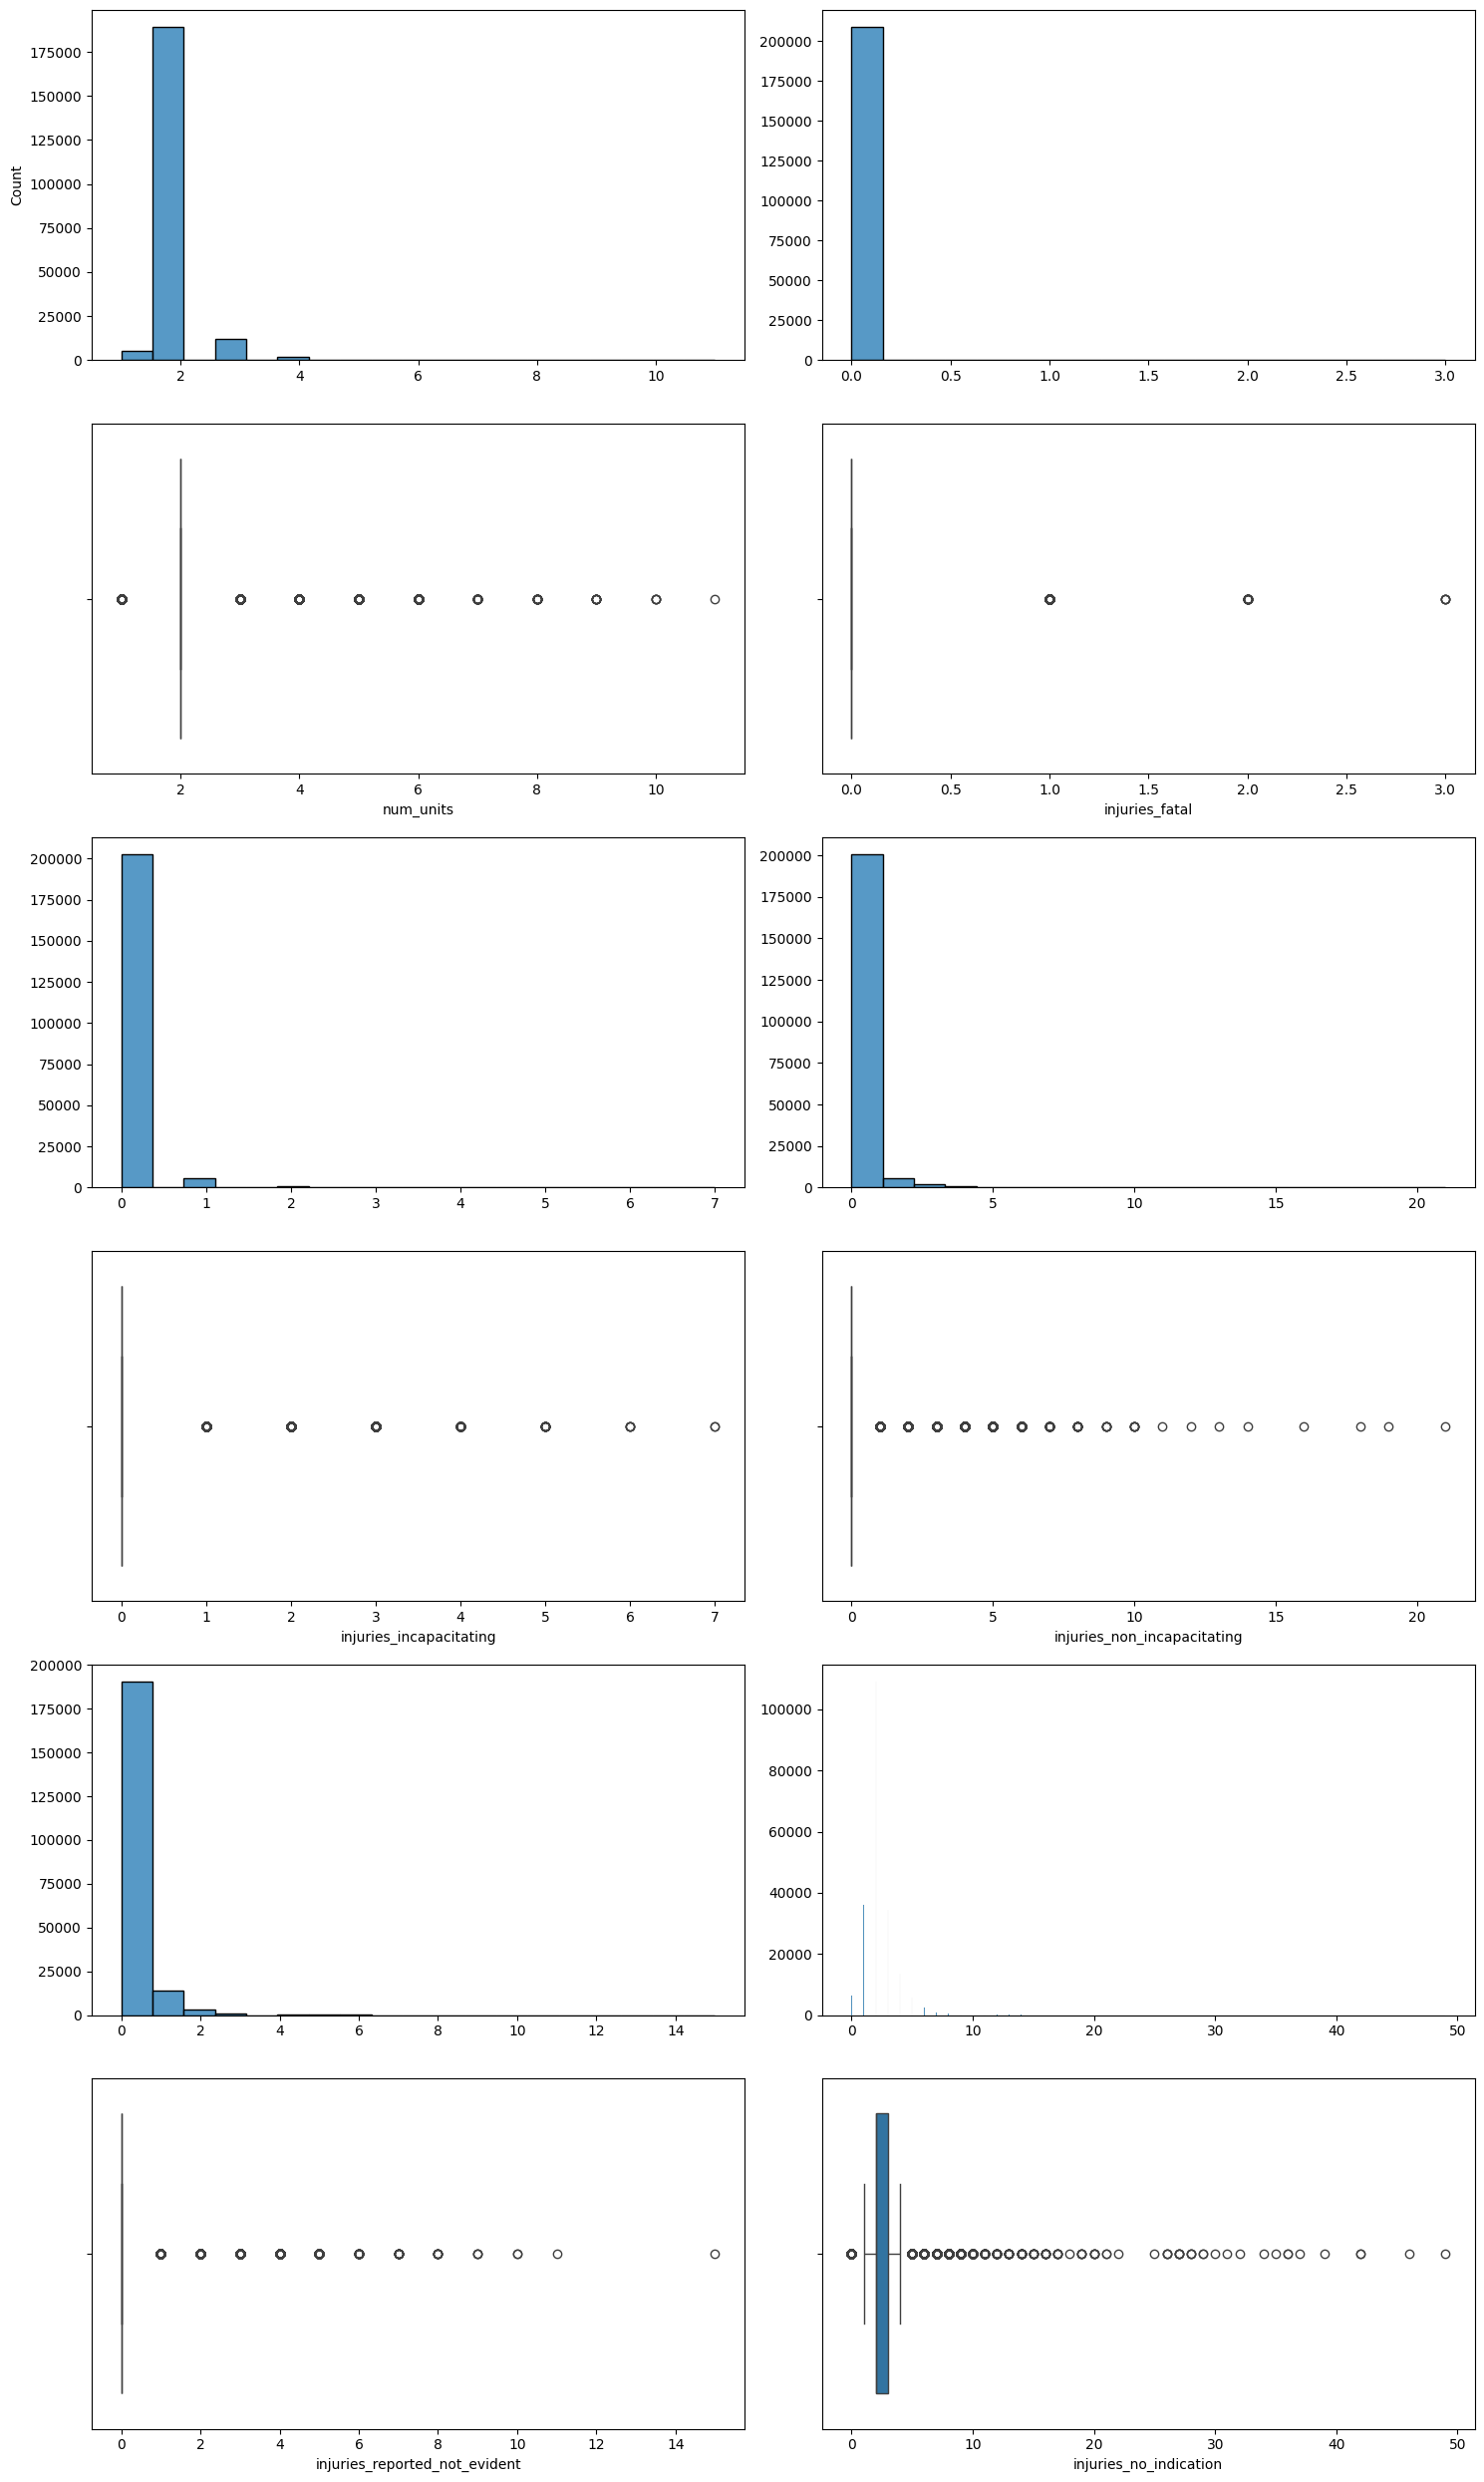

In [158]:
fig, axis = plt.subplots(6, 2, figsize = (15, 25))

# Creating a multiple figure with histograms and box plots
sns.histplot(ax = axis[0, 0], data = data, x = "num_units").set(xlabel = None)
sns.boxplot(ax = axis[1, 0], data = data, x = "num_units")
sns.histplot(ax = axis[0, 1], data = data, x = "injuries_fatal").set(xlabel = None, ylabel = None)
sns.boxplot(ax = axis[1, 1], data = data, x = "injuries_fatal")
sns.histplot(ax = axis[2, 0], data = data, x = "injuries_incapacitating").set(xlabel = None, ylabel = None)
sns.boxplot(ax = axis[3, 0], data = data, x = "injuries_incapacitating")
sns.histplot(ax = axis[2, 1], data = data, x = "injuries_non_incapacitating").set(xlabel = None, ylabel = None)
sns.boxplot(ax = axis[3, 1], data = data, x = "injuries_non_incapacitating")
sns.histplot(ax = axis[4, 0], data = data, x = "injuries_reported_not_evident").set(xlabel = None, ylabel = None)
sns.boxplot(ax = axis[5, 0], data = data, x = "injuries_reported_not_evident")
sns.histplot(ax = axis[4, 1], data = data, x = "injuries_no_indication").set(xlabel = None, ylabel = None)
sns.boxplot(ax = axis[5, 1], data = data, x = "injuries_no_indication")

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()

Agregar explicación del porqué se consideran numéricas

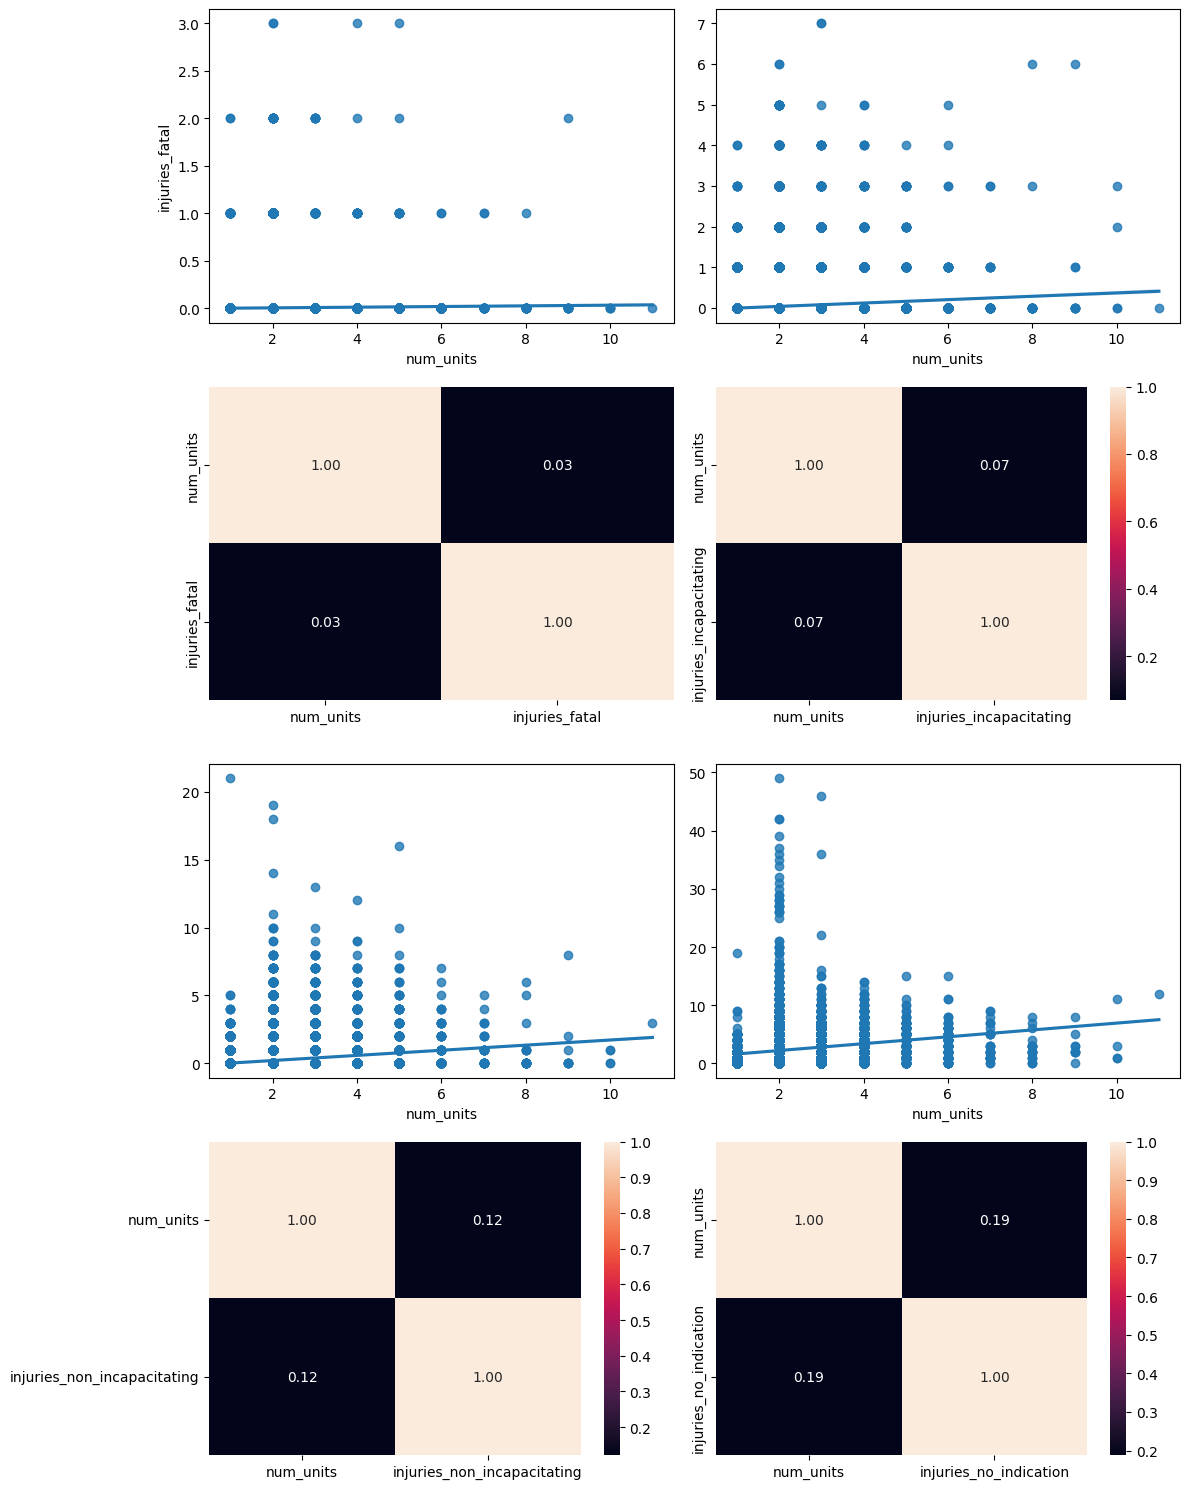

In [159]:
fig, axis = plt.subplots(4, 2, figsize = (12, 15))

# Create a multiple scatter diagram
sns.regplot(ax = axis[0, 0], data = data, x = "num_units", y = "injuries_fatal")
sns.heatmap(data[["num_units", "injuries_fatal"]].corr(), annot = True, fmt = ".2f", ax = axis[1, 0], cbar = False)
sns.regplot(ax = axis[0, 1], data = data, x = "num_units", y = "injuries_incapacitating").set(ylabel=None)
sns.heatmap(data[["num_units", "injuries_incapacitating"]].corr(), annot = True, fmt = ".2f", ax = axis[1, 1])
sns.regplot(ax = axis[2, 0], data = data, x = "num_units", y = "injuries_non_incapacitating").set(ylabel=None)
sns.heatmap(data[["num_units", "injuries_non_incapacitating"]].corr(), annot = True, fmt = ".2f", ax = axis[3, 0])
sns.regplot(ax = axis[2, 1], data = data, x = "num_units", y = "injuries_no_indication").set(ylabel=None)
sns.heatmap(data[["num_units", "injuries_no_indication"]].corr(), annot = True, fmt = ".2f", ax = axis[3, 1])

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()

Según los gráficos generados, no existe ninguna relación de peso entre las variables num_units e injuries (fatal, incapacitatin, non_incapacitating, no_indication). El valor más alto se obtiene con num_units y injuries_no_indication, pero se considera insuficiente para establecer una relación de valor.

/tmp/ipykernel_2192/2829552176.py:10: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


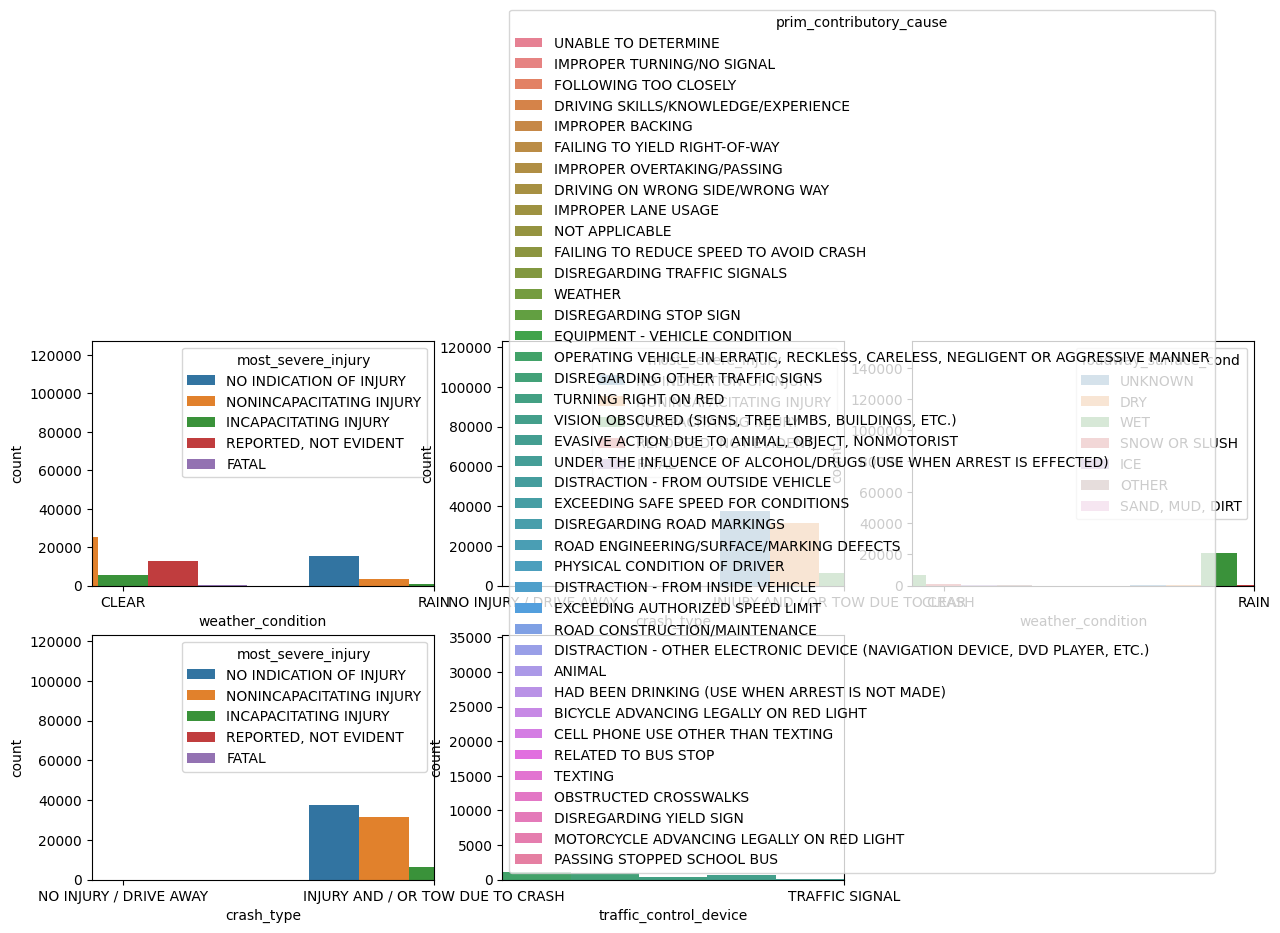

In [160]:
fig, axis = plt.subplots(2, 3, figsize = (15, 7))


sns.countplot(ax = axis[0, 0], data = data, x = "weather_condition", hue = "most_severe_injury", order=data['weather_condition'].value_counts().index).set_xlim(-0.1,1)
sns.countplot(ax = axis[0, 1], data = data, x = "crash_type", hue = "most_severe_injury").set_xlim(-0.1, 1)
sns.countplot(ax = axis[0, 2], data = data, x = "weather_condition", hue = "roadway_surface_cond").set_xlim(-0.1, 1)
sns.countplot(ax = axis[1, 0], data = data, x = "crash_type", hue = "most_severe_injury").set_xlim(-0.1, 1)
sns.countplot(ax = axis[1, 1], data = data, x = "traffic_control_device", hue = "prim_contributory_cause").set_xlim(-0.1, 0)

plt.tight_layout()

fig.delaxes(axis[1, 2])

plt.show()


/tmp/ipykernel_2192/2923313382.py:8: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


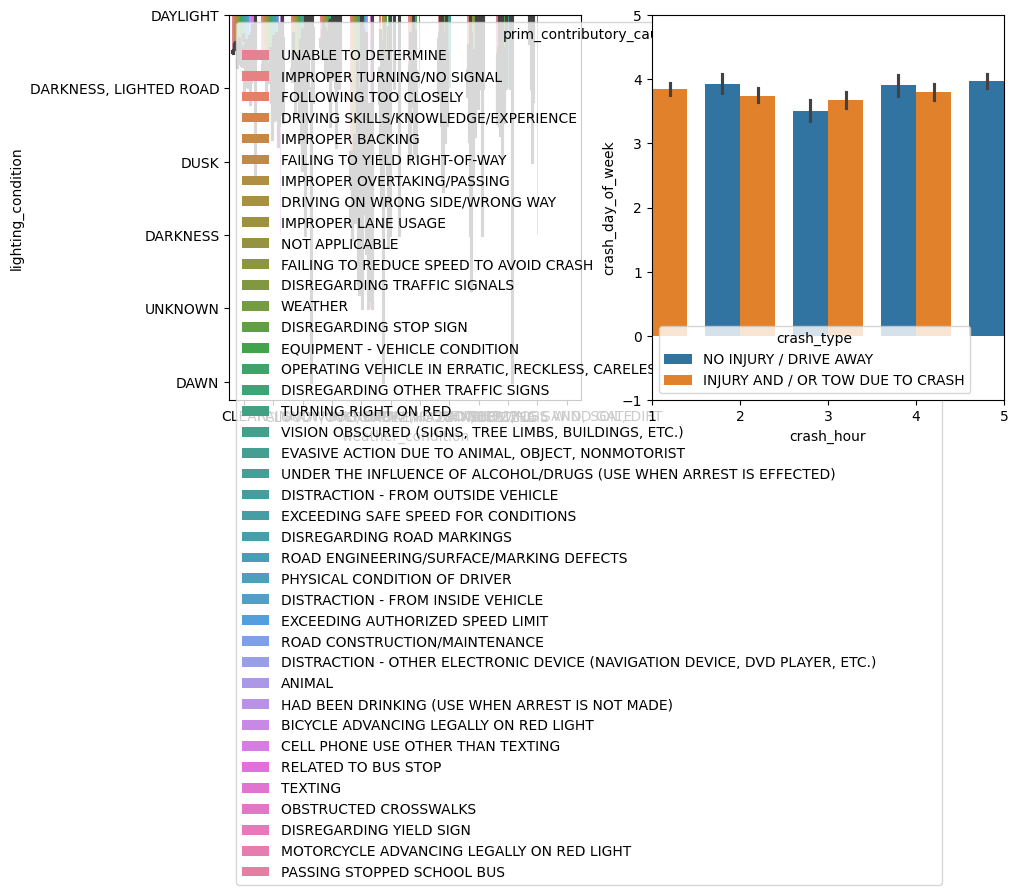

In [161]:
fig, axis = plt.subplots(figsize = (10, 5), ncols = 2)

sns.barplot(ax = axis[0], data = data, x = "weather_condition", y = "lighting_condition",hue = "prim_contributory_cause")
plt.xlim(1,5)
plt.ylim(-1,5)
sns.barplot(ax = axis[1], data = data, x = "crash_hour", y = "crash_day_of_week", hue = "crash_type")

plt.tight_layout()
plt.xlim(1,5)
plt.ylim(-1,5)
plt.show()

In [162]:
#Factorización de las variables categoricas
import pandas as pd

cols = data.select_dtypes(include=object)
cols = cols.columns

for x in cols:
    data[x] = pd.factorize(data[x])[0]



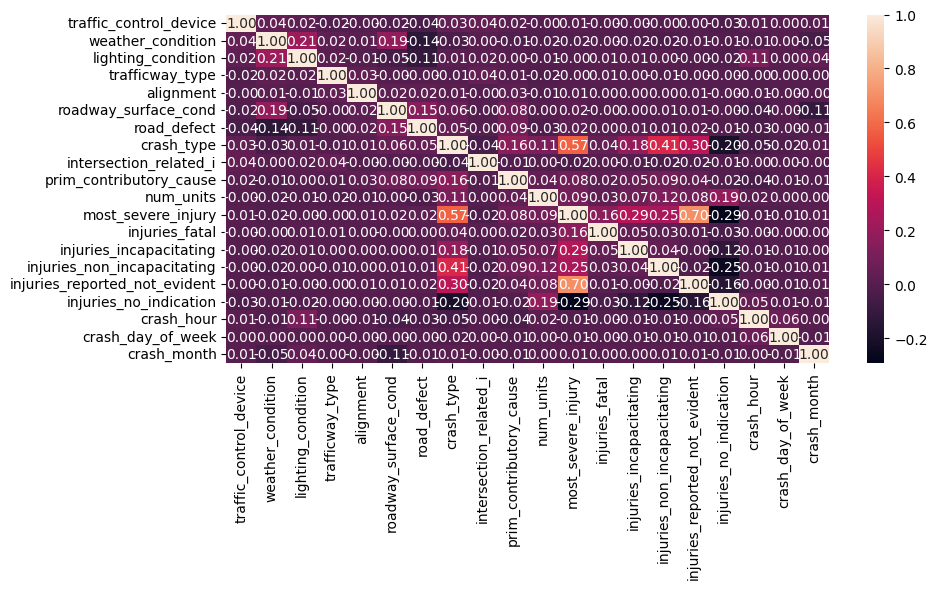

In [163]:
fig, axis = plt.subplots(figsize = (10, 6))

cols = data.columns
sns.heatmap(data[cols].corr(), annot = True, fmt = ".2f")

plt.tight_layout()

plt.show()

El heatmap nos arroja la siguiente información:
- La relación más fuerte existe entre injuries_reported_not_evident y most_severe_injury, con un 0.7, lo que indica que en la mayoría de los accidentes, las heridas no eran visibles y por lo tanto, no fueron reportadas o no eran incapacitantes
- La segunda relación más fuerte esta entre most_severe_injury y crash_type, lo que indica que dependiendo del tipo de choque será la herida más severa. 
- La tercera relacion más fuerte se encuentra entre crash_type e injuries_non_incapacitating, lo que indica de dependiendo del tipo de choque, las heridas pueden ser incapacitantes o no.

En cuanto a relaciones negativas, tenemos que:
- Most_severe_injury e injuries_no_indication, lo que tiene sentido, pues si la herida no es reportada, no se puede saber cuál es la más severa.
- injuries_non_incapacitating e injuries_no_indication, si la herida no es evidente, lo más probable es que no sea reportada.

In [164]:
data.describe()

,traffic_control_device,weather_condition,lighting_condition,trafficway_type,alignment,roadway_surface_cond,road_defect,crash_type,intersection_related_i,prim_contributory_cause,num_units,most_severe_injury,injuries_fatal,injuries_incapacitating,injuries_non_incapacitating,injuries_reported_not_evident,injuries_no_indication,crash_hour,crash_day_of_week,crash_month
count,209306.000000,209306.000000,209306.000000,209306.000000,209306.000000,209306.000000,209306.000000,209306.000000,209306.000000,209306.000000,209306.000000,209306.000000,209306.000000,209306.000000,209306.000000,209306.000000,209306.000000,209306.000000,209306.000000,209306.000000
mean,0.752587,0.470273,0.593848,2.375159,0.056984,1.184734,0.877992,0.439213,0.047691,5.255177,2.063300,0.450460,0.001859,0.038102,0.221241,0.121516,2.244002,13.373047,4.144024,6.771822
std,1.181821,1.161146,1.057929,3.400193,0.399250,0.629043,0.550384,0.496292,0.213112,5.716941,0.396012,0.889496,0.047502,0.233964,0.614960,0.450865,1.241175,5.603830,1.966864,3.427593
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,9.000000,2.000000,4.000000
50%,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,5.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,14.000000,4.000000,7.000000
75%,2.000000,0.000000,1.000000,3.000000,0.000000,1.000000,1.000000,1.000000,0.000000,9.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,3.000000,17.000000,6.000000,10.000000
max,18.000000,11.000000,5.000000,19.000000,5.000000,6.000000,6.000000,1.000000,1.000000,39.000000,11.000000,4.000000,3.000000,7.000000,21.000000,15.000000,49.000000,23.000000,7.000000,12.000000


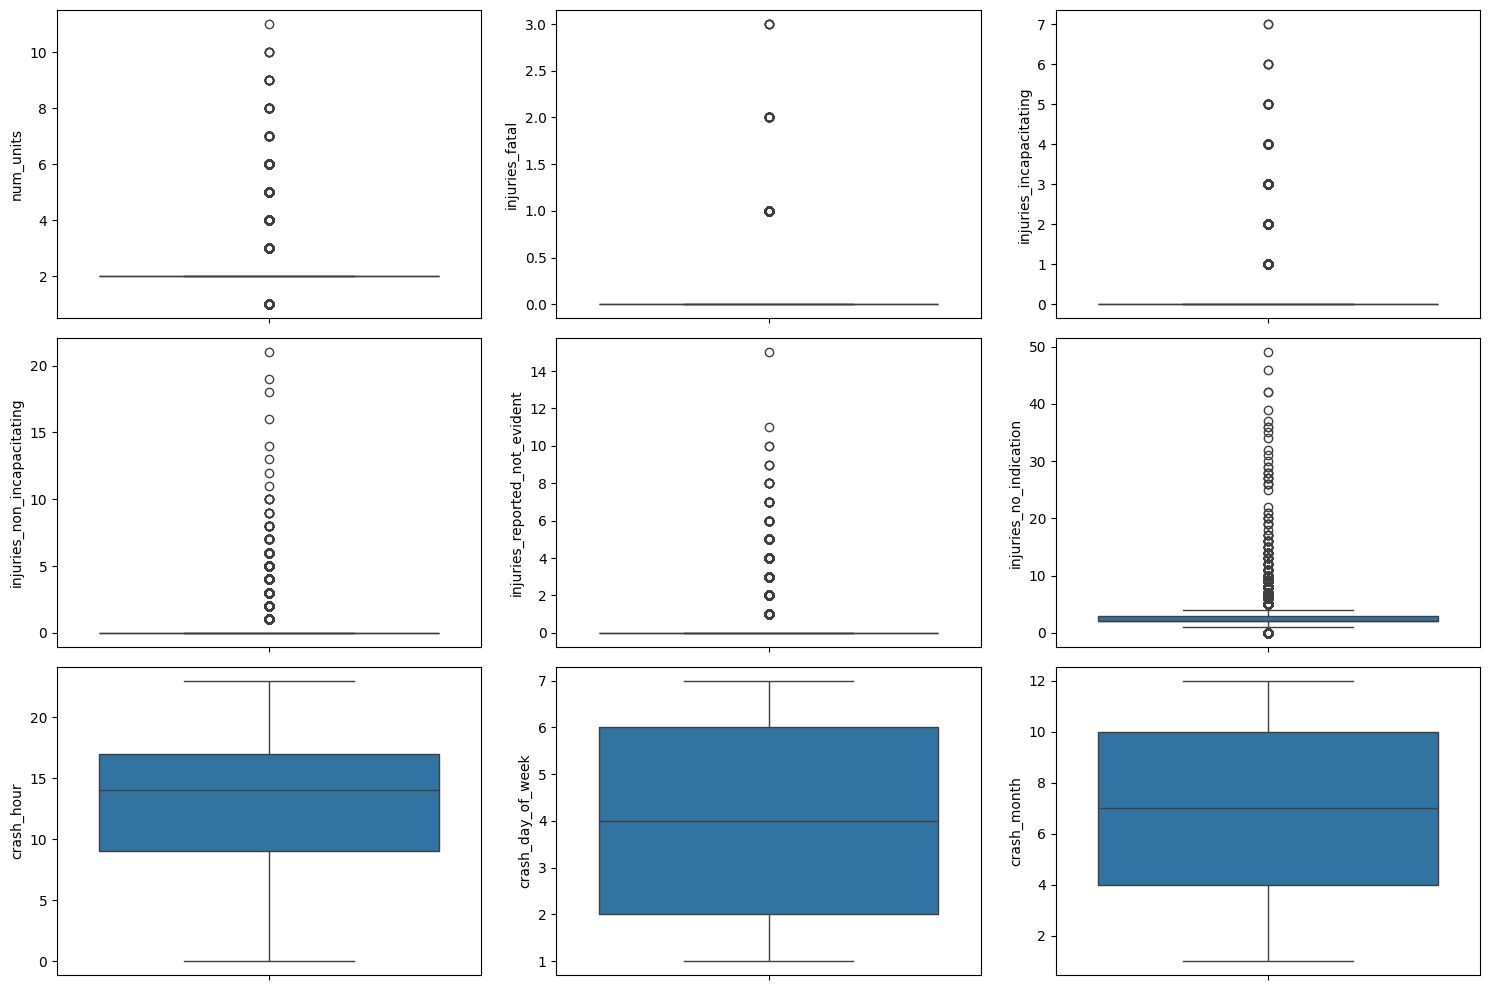

In [165]:
fig, axis = plt.subplots(3, 3, figsize = (15, 10))

sns.boxplot(ax = axis[0, 0], data = data, y = "num_units")
sns.boxplot(ax = axis[0, 1], data = total_data, y = "injuries_fatal")
sns.boxplot(ax = axis[0, 2], data = total_data, y = "injuries_incapacitating")
sns.boxplot(ax = axis[1, 0], data = total_data, y = "injuries_non_incapacitating")
sns.boxplot(ax = axis[1, 1], data = total_data, y = "injuries_reported_not_evident")
sns.boxplot(ax = axis[1, 2], data = total_data, y = "injuries_no_indication")
sns.boxplot(ax = axis[2, 0], data = total_data, y = "crash_hour")
sns.boxplot(ax = axis[2, 1], data = total_data, y = "crash_day_of_week")
sns.boxplot(ax = axis[2, 2], data = total_data, y = "crash_month")

plt.tight_layout()

plt.show()

Los gráficos obtenidos nos indican lo siguiente:
- La cantidad de unidades involucradas media se situa en 2, con una distribución de valores anormal, pues pueden encontrarse algunos valores atipicos que deben considerarse.
- La gravedad de las heridas se encuentra principalmente en 0, sin embargo existen varios valores atípicos que revisarse para definir si se mantienen o no.
- Los datos de la hora del accidente tienen una distribución más normal, sin tantos valores atípicos, lo que nos permite diferir que la hora en la que ocurre esta relacionada con las horas pico y valle.
- Los datos del día del accidente tienen una distribución más normal y uniforme, lo que nos indicaría que no hay una diferencia grande entre la ocurrencia por día. Lo mismo sucede con los datos de mes, donde la distribución también se mantiene estable.

In [166]:
data.isnull().sum().sort_values(ascending=False)

traffic_control_device           0
weather_condition                0
lighting_condition               0
trafficway_type                  0
alignment                        0
roadway_surface_cond             0
road_defect                      0
crash_type                       0
intersection_related_i           0
prim_contributory_cause          0
num_units                        0
most_severe_injury               0
injuries_fatal                   0
injuries_incapacitating          0
injuries_non_incapacitating      0
injuries_reported_not_evident    0
injuries_no_indication           0
crash_hour                       0
crash_day_of_week                0
crash_month                      0
dtype: int64

Ya que no se encontraron valores faltantes, no hay necesidad de realizar ningún procedimiento.

In [167]:
data["total_fatal_injuries"] =  data["injuries_fatal"] + data["injuries_incapacitating"]
data["total_non_fatal_injuries"] =  data["injuries_reported_not_evident"] + data["injuries_non_incapacitating"] + data["injuries_reported_not_evident"]

### Creación de los data sets train y test

In [168]:
from sklearn.model_selection import train_test_split

num_variables = data.columns.to_list()
num_variables.remove("most_severe_injury")
num_variables.remove("injuries_fatal")
num_variables.remove("injuries_incapacitating")
num_variables.remove("injuries_non_incapacitating")
num_variables.remove("injuries_reported_not_evident")
num_variables.remove("injuries_no_indication")

# We divide the dataset into training and test samples
X = data.drop("most_severe_injury", axis = 1)[num_variables]
y = data["most_severe_injury"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

X_train.head()

,traffic_control_device,weather_condition,lighting_condition,trafficway_type,alignment,roadway_surface_cond,road_defect,crash_type,intersection_related_i,prim_contributory_cause,num_units,crash_hour,crash_day_of_week,crash_month,total_fatal_injuries,total_non_fatal_injuries
145392,2,0,0,3,0,1,1,0,0,5,2,6,3,12,0.0,0.0
198372,0,0,0,1,0,1,1,0,0,5,2,15,7,8,0.0,0.0
13001,0,5,0,0,4,1,1,0,0,0,2,8,2,7,0.0,0.0
18163,2,0,0,1,0,1,1,1,0,0,1,16,7,8,0.0,1.0
131982,2,0,2,1,0,1,1,1,0,13,3,21,2,7,0.0,0.0


In [169]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(X_train)

X_train_mm = scaler.transform(X_train)
X_train_mm = pd.DataFrame(X_train_mm, index = X_train.index, columns = num_variables)

X_test_mm = scaler.transform(X_test)
X_test_mm = pd.DataFrame(X_test_mm, index = X_test.index, columns = num_variables)

X_train_mm.head()

,traffic_control_device,weather_condition,lighting_condition,trafficway_type,alignment,roadway_surface_cond,road_defect,crash_type,intersection_related_i,prim_contributory_cause,num_units,crash_hour,crash_day_of_week,crash_month,total_fatal_injuries,total_non_fatal_injuries
145392,0.111111,0.000000,0.0,0.157895,0.0,0.166667,0.166667,0.0,0.0,0.128205,0.111111,0.260870,0.333333,1.000000,0.0,0.000000
198372,0.000000,0.000000,0.0,0.052632,0.0,0.166667,0.166667,0.0,0.0,0.128205,0.111111,0.652174,1.000000,0.636364,0.0,0.000000
13001,0.000000,0.454545,0.0,0.000000,0.8,0.166667,0.166667,0.0,0.0,0.000000,0.111111,0.347826,0.166667,0.545455,0.0,0.000000
18163,0.111111,0.000000,0.0,0.052632,0.0,0.166667,0.166667,1.0,0.0,0.000000,0.000000,0.695652,1.000000,0.636364,0.0,0.043478
131982,0.111111,0.000000,0.4,0.052632,0.0,0.166667,0.166667,1.0,0.0,0.333333,0.222222,0.913043,0.166667,0.545455,0.0,0.000000


In [170]:
X_train_mm["most_severe_injury"] = list(y_train)
X_test_mm["most_severe_injury"] = list(y_test)

In [171]:
X_train_mm.to_csv("../data/processed/data_train.csv", index=False)
X_test_mm.to_csv("../data/processed/data_test.csv", index=False)